In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None) ## 모든 열을 출력한다
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

import seaborn as sns 

import warnings
warnings.filterwarnings('ignore')
import wget
import os

from casting.preprocessing import calculate_defect_rate
from casting.configuration import columns

import math

from scipy.stats import f_oneway
from scipy.stats import ttest_ind

import koreanize_matplotlib

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

import shap
from pdpbox.pdp import PDPIsolate

In [2]:
# 글꼴 파일을 다운로드할 URL
# font_url = "https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Bold.ttf"
# 글꼴 파일을 다운로드
# font_path = wget.download(font_url, out='NanumGothic-Bold.ttf')
# 다운로드한 글꼴 파일 경로를 Matplotlib에 등록
font_manager.fontManager.addfont('NanumGothic-Bold.ttf')
plt.rc('font', family='NanumGothic')

In [3]:
# 데이터 불러오기
df_origin = pd.read_csv('casting/data/raw/casting_data_origin.csv', encoding = 'euc-kr')
df = df_origin[columns.use_columns]

# 제조 데이터 정의 및 처리 과정

In [4]:
# 데이터 컬럼 확인
df_origin.columns

Index(['Unnamed: 0', 'line', 'name', 'mold_name', 'time', 'date', 'count',
       'working', 'emergency_stop', 'molten_temp',
       'facility_operation_cycleTime', 'production_cycletime',
       'low_section_speed', 'high_section_speed', 'molten_volume',
       'cast_pressure', 'biscuit_thickness', 'upper_mold_temp1',
       'upper_mold_temp2', 'upper_mold_temp3', 'lower_mold_temp1',
       'lower_mold_temp2', 'lower_mold_temp3', 'sleeve_temperature',
       'physical_strength', 'Coolant_temperature', 'EMS_operation_time',
       'registration_time', 'passorfail', 'tryshot_signal', 'mold_code',
       'heating_furnace'],
      dtype='object')

## 완전성

In [5]:
# 데이터 결측치 확인
df_origin.isna().sum()

Unnamed: 0                          0
line                                0
name                                0
mold_name                           0
time                                0
date                                0
count                               0
working                             1
emergency_stop                      1
molten_temp                      2261
facility_operation_cycleTime        0
production_cycletime                0
low_section_speed                   1
high_section_speed                  1
molten_volume                   45130
cast_pressure                       1
biscuit_thickness                   1
upper_mold_temp1                    1
upper_mold_temp2                    1
upper_mold_temp3                  313
lower_mold_temp1                    1
lower_mold_temp2                    1
lower_mold_temp3                  313
sleeve_temperature                  1
physical_strength                   1
Coolant_temperature                 1
EMS_operatio

In [6]:
# EMS_operaion_time 컬럼 value 값 확인
df_origin['EMS_operation_time'].value_counts()

23    69953
6     11269
0      7027
3      3454
25      312
Name: EMS_operation_time, dtype: int64

In [7]:
# 데이터 프레임 3개 확인
df_origin.head(3)

,Unnamed: 0,line,name,mold_name,time,date,count,working,emergency_stop,molten_temp,facility_operation_cycleTime,production_cycletime,low_section_speed,high_section_speed,molten_volume,cast_pressure,biscuit_thickness,upper_mold_temp1,upper_mold_temp2,upper_mold_temp3,lower_mold_temp1,lower_mold_temp2,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,registration_time,passorfail,tryshot_signal,mold_code,heating_furnace
0,0,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019.1.2,16:45:06,258,가동,ON,731.0,119,120,110.0,112.0,75.0,331.0,35.0,198.0,116.0,1449.0,234.0,316.0,1449.0,550.0,700.0,34.0,23,2019.1.2 16:45,0.0,NaN,8722,NaN
1,1,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019.1.2,16:45:08,243,가동,ON,720.0,98,125,109.0,109.0,NaN,309.0,48.0,250.0,113.0,NaN,208.0,163.0,NaN,481.0,0.0,30.0,25,2019.1.2 16:45,0.0,NaN,8412,B
2,2,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019.1.2,16:45:58,244,가동,ON,721.0,98,122,109.0,109.0,NaN,309.0,48.0,250.0,113.0,NaN,208.0,163.0,NaN,481.0,0.0,30.0,25,2019.1.2 16:45,0.0,NaN,8412,B


In [8]:
# date, time 컬럼 제거
df_origin = df_origin.drop(['date', 'time'], axis = 1)

In [9]:
# 결측치가 많은 molten_volume, tryshot_signal, heating_furnace 컬럼 제거
df_origin = df_origin.drop(['molten_volume', 'tryshot_signal', 'heating_furnace'], axis = 1)

## 유일성

In [10]:
# 각 컬럼별 고유값 갯수 확인
df_origin.nunique()

Unnamed: 0                      92015
line                                1
name                                1
mold_name                           1
count                             334
working                             2
emergency_stop                      1
molten_temp                       113
facility_operation_cycleTime      195
production_cycletime              202
low_section_speed                 123
high_section_speed                230
cast_pressure                     124
biscuit_thickness                  67
upper_mold_temp1                  317
upper_mold_temp2                  232
upper_mold_temp3                  117
lower_mold_temp1                  345
lower_mold_temp2                  323
lower_mold_temp3                  314
sleeve_temperature                590
physical_strength                 106
Coolant_temperature                35
EMS_operation_time                  5
registration_time               68545
passorfail                          2
mold_code   

In [11]:
# 단일 값을 가지는 열 제거
df_origin = df_origin.drop(['line', 'name', 'mold_name', 'emergency_stop'], axis = 1)


In [12]:
# EMS_operation_time 값별 갯수 확인
df_origin['EMS_operation_time'].value_counts()

23    69953
6     11269
0      7027
3      3454
25      312
Name: EMS_operation_time, dtype: int64

# 이상치 처리 관련

## 시간 순서에 따른 불량 발생, 특별히 튀는 기기상의 문제가 존재하는가?
- 불량이 많이 발생한 시간과 grouping 지어지는 column이 있는가? cast_prresure이 존재함

In [ ]:
# 그룹 나누기 (값이 변경되는 위치에서 구분)
df_origin['group'] = (df_origin['passorfail'] != df_origin['passorfail'].shift()).cumsum()

# 연속된 불량 구간만 필터링하여 기간 측정
fail_segments = df_origin[df_origin['passorfail'] == 1].groupby('group').agg(
    start_time=('registration_time', 'first'),
    end_time=('registration_time', 'last'),
    duration=('registration_time', 'count')  # 연속된 구간의 길이
).reset_index()

# 연속된 구간 중 길이가 일정 수준 이상인 경우 필터링
long_fail_segments = fail_segments[fail_segments['duration'] > 1]  # 연속된 구간이 2 이상인 경우


In [14]:
long_fail_segments.sort_values(by = 'duration', ascending = False)

,group,start_time,end_time,duration
1184,2371,2019.2.15 8:27,2019.2.15 11:07,20
1889,3781,2019.3.8 20:09,2019.3.8 20:24,16
1375,2753,2019.2.21 7:58,2019.2.21 8:11,16
2021,4045,2019.3.11 8:01,2019.3.11 8:12,16
1776,3555,2019.3.6 19:55,2019.3.6 20:07,15
...,...,...,...,...
423,848,2019.1.24 13:53,2019.1.24 13:55,2
405,812,2019.1.23 15:49,2019.1.23 15:51,2
1757,3517,2019.3.5 8:16,2019.3.5 8:16,2
385,772,2019.1.22 23:54,2019.1.22 23:56,2


## 불량이 연속적으로 발생한 구간동안 지속되는 feature와 전후로 변경된 feature가 있는지 확인

In [15]:
group_name = [2371, 3781, 4045, 2753, 3615]
before_group = [2370, 3780, 4044, 2752, 3614]
after_group = [2372, 3782, 4046, 2754, 3613]
error_df = df_origin[df_origin['group'].isin(group_name)]
before_df = df_origin[df_origin['group'].isin(before_group)]
after_df = df_origin[df_origin['group'].isin(after_group)]


In [16]:
time_group = [2752, 2753, 2754]
#[3780, 3781, 3782]
#[4044, 4045, 4046]
#[2752, 2753, 2754]
#[2370, 2371, 2372]
time_df = df_origin[df_origin['group'].isin(time_group)]
time_df

,Unnamed: 0,count,working,molten_temp,facility_operation_cycleTime,production_cycletime,low_section_speed,high_section_speed,cast_pressure,biscuit_thickness,upper_mold_temp1,upper_mold_temp2,upper_mold_temp3,lower_mold_temp1,lower_mold_temp2,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,registration_time,passorfail,mold_code,group
46995,46995,141,가동,730.0,123,125,105.0,107.0,325.0,50.0,197.0,180.0,1449.0,248.0,247.0,1449.0,444.0,691.0,34.0,23,2019.2.21 3:44,0.0,8722,2752
46996,46996,153,가동,733.0,118,120,110.0,112.0,330.0,49.0,226.0,175.0,1449.0,133.0,257.0,1449.0,158.0,715.0,35.0,23,2019.2.21 3:44,0.0,8412,2752
46997,46997,219,가동,728.0,179,118,110.0,112.0,329.0,48.0,138.0,164.0,1449.0,201.0,153.0,1449.0,383.0,704.0,33.0,23,2019.2.21 3:46,0.0,8917,2752
46998,46998,154,가동,733.0,117,119,110.0,112.0,333.0,49.0,200.0,175.0,1449.0,134.0,257.0,1449.0,159.0,709.0,35.0,23,2019.2.21 3:46,0.0,8412,2752
46999,46999,142,가동,729.0,122,126,105.0,107.0,324.0,50.0,198.0,181.0,1449.0,249.0,248.0,1449.0,446.0,695.0,34.0,23,2019.2.21 3:46,0.0,8722,2752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47292,47292,5,가동,730.0,114,116,110.0,113.0,159.0,49.0,206.0,143.0,1449.0,84.0,186.0,1449.0,135.0,704.0,27.0,23,2019.2.21 8:10,1.0,8412,2753
47293,47293,7,가동,727.0,114,119,110.0,112.0,330.0,54.0,139.0,158.0,1449.0,200.0,152.0,1449.0,394.0,708.0,26.0,23,2019.2.21 8:10,1.0,8917,2753
47294,47294,4,가동,729.0,118,125,105.0,107.0,331.0,41.0,144.0,100.0,1449.0,124.0,165.0,1449.0,511.0,682.0,22.0,23,2019.2.21 8:11,1.0,8917,2753
47295,47295,6,가동,730.0,113,117,110.0,112.0,330.0,52.0,210.0,143.0,1449.0,89.0,198.0,1449.0,144.0,702.0,27.0,23,2019.2.21 8:12,0.0,8412,2754


In [17]:
time_df.groupby('group').nunique()

,Unnamed: 0,count,working,molten_temp,facility_operation_cycleTime,production_cycletime,low_section_speed,high_section_speed,cast_pressure,biscuit_thickness,upper_mold_temp1,upper_mold_temp2,upper_mold_temp3,lower_mold_temp1,lower_mold_temp2,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,registration_time,passorfail,mold_code
group,,,,,,,,,,,,,,,,,,,,,,,
2752,284,173,1,27,36,36,2,7,10,22,64,23,1,47,45,1,55,38,4,1,162,1,3
2753,16,7,1,5,4,9,8,3,11,12,16,13,1,16,14,1,15,15,4,1,9,1,2
2754,2,2,1,2,2,2,1,1,1,2,2,2,1,2,2,1,2,2,1,1,1,1,2


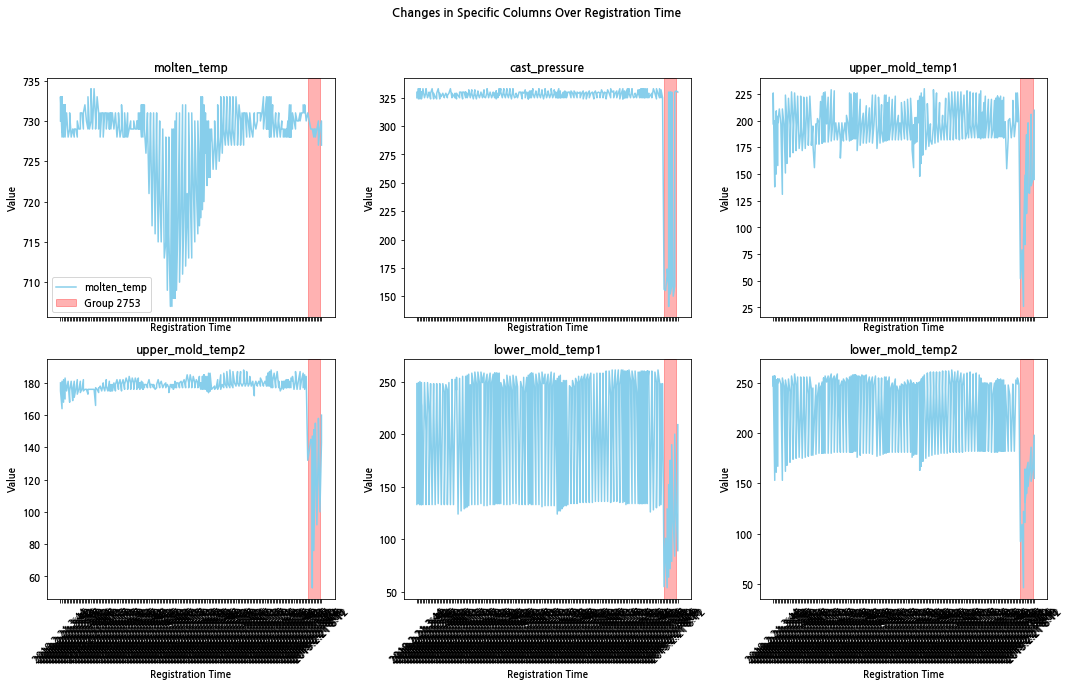

In [18]:
specific_cols = ['molten_temp', 'cast_pressure', 'upper_mold_temp1', 'upper_mold_temp2', 'lower_mold_temp1', 'lower_mold_temp2']

# figure와 subplot 생성 (2x3 형태)
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True)
fig.suptitle('Changes in Specific Columns Over Registration Time')

# group 값이 3615인 registration_time 구간을 찾기
highlight_start = time_df[time_df['group'] == 2753]['registration_time'].min()
highlight_end = time_df[time_df['group'] == 2753]['registration_time'].max()

# 각 specific_cols의 변화를 subplot에 그리기
for i, col in enumerate(specific_cols):
    row = i // 3
    col_pos = i % 3

    # 전체 데이터를 기본 색상으로 플롯
    axes[row, col_pos].plot(time_df['registration_time'], time_df[col], label=col, color='skyblue')
    
    # group이 3615인 구간을 배경색으로 강조
    axes[row, col_pos].axvspan(highlight_start, highlight_end, color='red', alpha=0.3, label='Group 2753')

    # 제목 및 축 레이블 설정
    axes[row, col_pos].set_title(col)
    axes[row, col_pos].set_xlabel('Registration Time')
    axes[row, col_pos].set_ylabel('Value')
    axes[row, col_pos].tick_params(axis='x', rotation=45)


# 범례 추가 (하나의 subplot에만 표시되도록 설정)
axes[0, 0].legend()

# 레이아웃 조정
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


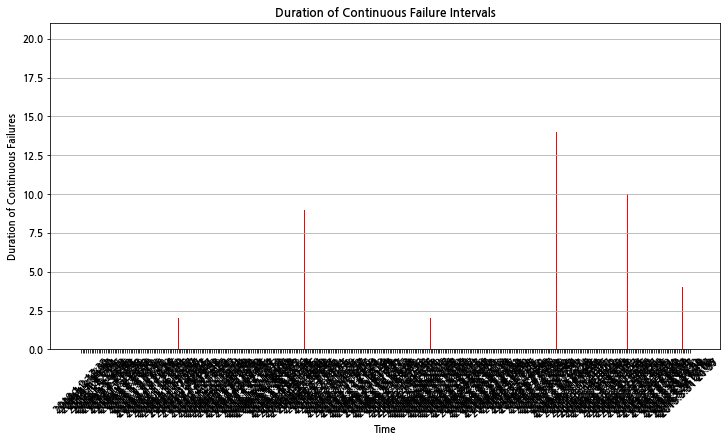

In [ ]:
# 시각화를 위해 데이터 준비
plt.figure(figsize=(12, 6))

# duration을 y축으로 사용하여 막대 그래프 생성
plt.bar(long_fail_segments['start_time'], long_fail_segments['duration'], color='red', width=0.01)

# 타임스탬프 축 및 기타 설정
plt.xlabel('Time')
plt.ylabel('Duration of Continuous Failures')
plt.title('Duration of Continuous Failure Intervals')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


## mold_code가 양품, 불량에 영향을 미치는가?

In [20]:
data = df_origin.copy()
data = data.dropna()
data = data.reset_index(drop = True)
data = data.drop('registration_time', axis = 1)

In [21]:
data.isna().sum()

Unnamed: 0                      0
count                           0
working                         0
molten_temp                     0
facility_operation_cycleTime    0
production_cycletime            0
low_section_speed               0
high_section_speed              0
cast_pressure                   0
biscuit_thickness               0
upper_mold_temp1                0
upper_mold_temp2                0
upper_mold_temp3                0
lower_mold_temp1                0
lower_mold_temp2                0
lower_mold_temp3                0
sleeve_temperature              0
physical_strength               0
Coolant_temperature             0
EMS_operation_time              0
passorfail                      0
mold_code                       0
group                           0
dtype: int64

In [22]:
df.isna().sum()

molten_temp                     2261
facility_operation_cycleTime       0
production_cycletime               0
low_section_speed                  1
high_section_speed                 1
cast_pressure                      1
biscuit_thickness                  1
upper_mold_temp1                   1
upper_mold_temp2                   1
upper_mold_temp3                 313
lower_mold_temp1                   1
lower_mold_temp2                   1
lower_mold_temp3                 313
sleeve_temperature                 1
physical_strength                  1
Coolant_temperature                1
EMS_operation_time                 0
mold_code                          0
passorfail                         1
dtype: int64

In [23]:
data.columns
feature_list = ['molten_temp', 'facility_operation_cycleTime', 'production_cycletime',
       'low_section_speed', 'high_section_speed', 'cast_pressure',
       'biscuit_thickness', 'upper_mold_temp1', 'upper_mold_temp2',
       'upper_mold_temp3', 'lower_mold_temp1', 'lower_mold_temp2',
       'lower_mold_temp3', 'sleeve_temperature', 'physical_strength',
       'Coolant_temperature', 'EMS_operation_time']

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89441 entries, 0 to 89440
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    89441 non-null  int64  
 1   count                         89441 non-null  int64  
 2   working                       89441 non-null  object 
 3   molten_temp                   89441 non-null  float64
 4   facility_operation_cycleTime  89441 non-null  int64  
 5   production_cycletime          89441 non-null  int64  
 6   low_section_speed             89441 non-null  float64
 7   high_section_speed            89441 non-null  float64
 8   cast_pressure                 89441 non-null  float64
 9   biscuit_thickness             89441 non-null  float64
 10  upper_mold_temp1              89441 non-null  float64
 11  upper_mold_temp2              89441 non-null  float64
 12  upper_mold_temp3              89441 non-null  float64
 13  l

### mold code에 대한 ANOVA, Mutual Information 확인

In [ ]:
# 각 feature마다 ANOVA 테스트 수행
for feature in feature_list:
    groups = [data[data['mold_code'] == code][feature] for code in data['mold_code'].unique()]
    f_stat, p_value = f_oneway(*groups)
    print(f'{feature} - p-value: {p_value}')


molten_temp - p-value: 0.0
facility_operation_cycleTime - p-value: 7.282622394138408e-182
production_cycletime - p-value: 1.176144517569648e-143
low_section_speed - p-value: 0.2210705606583038
high_section_speed - p-value: 0.0
cast_pressure - p-value: 8.698225001256704e-47
biscuit_thickness - p-value: 1.3414302225442181e-192
upper_mold_temp1 - p-value: 0.0
upper_mold_temp2 - p-value: 0.0
upper_mold_temp3 - p-value: 0.0
lower_mold_temp1 - p-value: 0.0
lower_mold_temp2 - p-value: 0.0
lower_mold_temp3 - p-value: 5.704593091653792e-68
sleeve_temperature - p-value: 0.0
physical_strength - p-value: 2.864486994393828e-14
Coolant_temperature - p-value: 4.6958836199227046e-127
EMS_operation_time - p-value: 0.0


In [ ]:
# 수치형 feature에 대한 mutual information 계산
numerical_features = data.select_dtypes(include=['float64', 'int']).columns
mi_scores = mutual_info_regression(data[numerical_features], data['mold_code'])

# 결과 출력
for feature, score in zip(numerical_features, mi_scores):
    print(f'{feature} - Mutual Information Score: {score}')


Unnamed: 0 - Mutual Information Score: 0.6881867664542582
count - Mutual Information Score: 0.0
molten_temp - Mutual Information Score: 0.2593771334782291
facility_operation_cycleTime - Mutual Information Score: 0.15664549102700853
production_cycletime - Mutual Information Score: 0.18192278901721526
low_section_speed - Mutual Information Score: 0.2711808218334011
high_section_speed - Mutual Information Score: 0.2776175032107231
cast_pressure - Mutual Information Score: 0.5098303957522372
biscuit_thickness - Mutual Information Score: 0.16173915905288982
upper_mold_temp1 - Mutual Information Score: 0.5000252537179035
upper_mold_temp2 - Mutual Information Score: 0.5505226342660414
upper_mold_temp3 - Mutual Information Score: 0.29641081971405914
lower_mold_temp1 - Mutual Information Score: 0.5082824651627051
lower_mold_temp2 - Mutual Information Score: 0.3805234723681199
lower_mold_temp3 - Mutual Information Score: 0.02980973582981683
sleeve_temperature - Mutual Information Score: 0.519042

## 이상치 제거 과정

In [27]:
data.corr()

,Unnamed: 0,count,molten_temp,facility_operation_cycleTime,production_cycletime,low_section_speed,high_section_speed,cast_pressure,biscuit_thickness,upper_mold_temp1,upper_mold_temp2,upper_mold_temp3,lower_mold_temp1,lower_mold_temp2,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,passorfail,mold_code,group
Unnamed: 0,1.000000,0.026254,0.086963,-0.004784,-0.033504,0.000100,-0.118756,-0.003326,-0.008465,0.150327,0.181566,0.517199,0.095429,0.341166,-0.030130,-0.583277,-0.009065,-0.034652,-0.458284,-0.005953,0.055018,0.998783
count,0.026254,1.000000,0.009530,-0.001568,0.034207,-0.006152,0.009265,0.178554,-0.049996,0.081299,0.178112,0.024972,0.137455,0.103902,0.000444,0.027257,-0.000757,0.033799,0.015336,-0.179249,0.005531,0.025391
molten_temp,0.086963,0.009530,1.000000,-0.002506,-0.014795,-0.000928,-0.041426,-0.008509,0.012011,0.058528,-0.002658,-0.008410,-0.015231,0.030654,0.013824,-0.084688,0.004307,-0.003044,-0.116416,0.002813,-0.025256,0.088164
facility_operation_cycleTime,-0.004784,-0.001568,-0.002506,1.000000,0.044940,0.000264,-0.023998,-0.000307,-0.004061,-0.022949,-0.027953,-0.079448,-0.071998,-0.006956,0.005765,-0.003670,-0.002231,-0.001304,-0.008665,-0.006363,-0.030366,-0.007135
production_cycletime,-0.033504,0.034207,-0.014795,0.044940,1.000000,0.003281,0.018419,0.102082,-0.043665,-0.057945,-0.015727,-0.065476,-0.052636,0.008393,-0.004284,0.013548,-0.007046,0.011347,0.011593,-0.083361,-0.046024,-0.035460
low_section_speed,0.000100,-0.006152,-0.000928,0.000264,0.003281,1.000000,0.008690,-0.030388,0.082616,-0.002658,-0.006929,0.000485,-0.002829,-0.002064,0.000743,-0.006808,-0.011147,-0.000779,0.003299,0.013946,-0.005372,0.000073
high_section_speed,-0.118756,0.009265,-0.041426,-0.023998,0.018419,0.008690,1.000000,0.002986,-0.054018,-0.004955,-0.000680,-0.022435,-0.050096,0.000048,0.006866,0.007871,0.010463,0.032920,0.072574,0.117678,-0.086433,-0.125209
cast_pressure,-0.003326,0.178554,-0.008509,-0.000307,0.102082,-0.030388,0.002986,1.000000,-0.275901,0.180574,0.207201,0.008237,0.268454,0.236752,0.006239,0.113089,-0.007929,0.045320,0.039562,-0.756498,0.027911,-0.004142
biscuit_thickness,-0.008465,-0.049996,0.012011,-0.004061,-0.043665,0.082616,-0.054018,-0.275901,1.000000,-0.075365,-0.049266,-0.053695,-0.125851,-0.095327,-0.005279,-0.079459,0.034559,-0.015349,-0.053977,0.187421,-0.004260,-0.009293
upper_mold_temp1,0.150327,0.081299,0.058528,-0.022949,-0.057945,-0.002658,-0.004955,0.180574,-0.075365,1.000000,0.265525,-0.246561,0.088497,0.411215,0.049080,-0.029054,-0.001112,-0.018995,-0.166531,-0.228887,-0.313909,0.159161


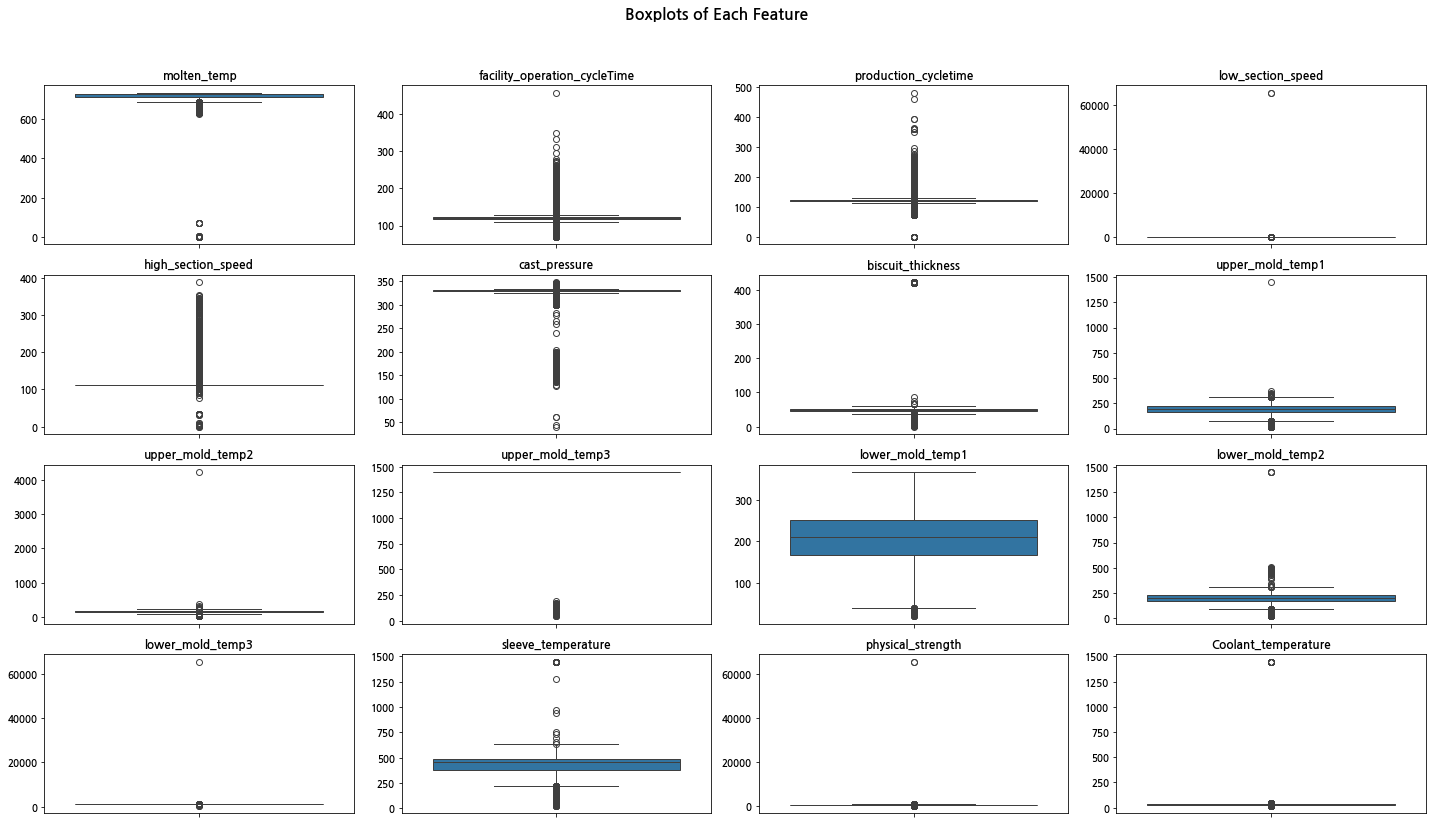

In [ ]:
# 3x6 형태로 Subplot 생성
fig, axes = plt.subplots(4, 4, figsize=(20, 12))
fig.suptitle('Boxplots of Each Feature', fontsize=16)

# 컬럼 목록
columns = ['molten_temp', 'facility_operation_cycleTime', 'production_cycletime',
       'low_section_speed', 'high_section_speed', 'cast_pressure',
       'biscuit_thickness', 'upper_mold_temp1', 'upper_mold_temp2',
       'upper_mold_temp3', 'lower_mold_temp1', 'lower_mold_temp2',
       'lower_mold_temp3', 'sleeve_temperature', 'physical_strength',
       'Coolant_temperature']

# 각 컬럼에 대해 Boxplot 그리기
for i, col in enumerate(columns):
    row = i // 4
    col_pos = i % 4
    sns.boxplot(data=data, y=col, ax=axes[row, col_pos])
    axes[row, col_pos].set_title(col)
    axes[row, col_pos].set_xlabel('')
    axes[row, col_pos].set_ylabel('')

# 레이아웃 조정
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [29]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,89441.0,46965.412495,26312.523893,0.0,24934.0,47294.0,69654.0,92014.0
count,89441.0,148.473541,87.941536,1.0,72.0,146.0,222.0,334.0
molten_temp,89441.0,718.625172,51.818655,0.0,713.0,728.0,730.0,735.0
facility_operation_cycleTime,89441.0,121.702239,12.169837,69.0,117.0,119.0,122.0,457.0
production_cycletime,89441.0,122.318925,12.549906,0.0,119.0,121.0,123.0,482.0
low_section_speed,89441.0,110.067922,309.504180,0.0,110.0,110.0,110.0,65535.0
high_section_speed,89441.0,111.837960,9.646943,0.0,112.0,112.0,112.0,388.0
cast_pressure,89441.0,324.527219,27.308033,41.0,329.0,330.0,331.0,348.0
biscuit_thickness,89441.0,50.717881,18.043014,0.0,47.0,50.0,53.0,422.0
upper_mold_temp1,89441.0,186.058821,46.343803,18.0,162.0,195.0,222.0,1449.0


In [30]:
feature_list.remove('EMS_operation_time')

In [31]:
feature_list

['molten_temp',
 'facility_operation_cycleTime',
 'production_cycletime',
 'low_section_speed',
 'high_section_speed',
 'cast_pressure',
 'biscuit_thickness',
 'upper_mold_temp1',
 'upper_mold_temp2',
 'upper_mold_temp3',
 'lower_mold_temp1',
 'lower_mold_temp2',
 'lower_mold_temp3',
 'sleeve_temperature',
 'physical_strength',
 'Coolant_temperature']

In [32]:
data1 = data.copy()
for	col	in feature_list:
 UCL = np.percentile(data1[col],99.99)
 data1 = data1[data1[col]<=UCL]
 data1.reset_index(drop=True, inplace=True)

In [33]:
data1.describe().T[['min', 'max']]

,min,max
Unnamed: 0,0.0,92014.0
count,1.0,334.0
molten_temp,0.0,735.0
facility_operation_cycleTime,69.0,268.0
production_cycletime,0.0,360.0
low_section_speed,0.0,150.0
high_section_speed,0.0,340.0
cast_pressure,41.0,344.0
biscuit_thickness,0.0,422.0
upper_mold_temp1,18.0,332.0


In [34]:
skewness = data[feature_list].skew()
skewness

molten_temp                     -13.221276
facility_operation_cycleTime      5.587384
production_cycletime              5.650013
low_section_speed               211.216519
high_section_speed               10.454152
cast_pressure                    -5.759129
biscuit_thickness                19.256576
upper_mold_temp1                 -0.331330
upper_mold_temp2                 22.964216
upper_mold_temp3                 -2.668052
lower_mold_temp1                 -0.277017
lower_mold_temp2                  1.015556
lower_mold_temp3                268.781468
sleeve_temperature               -0.708997
physical_strength               208.442043
Coolant_temperature              94.781610
dtype: float64

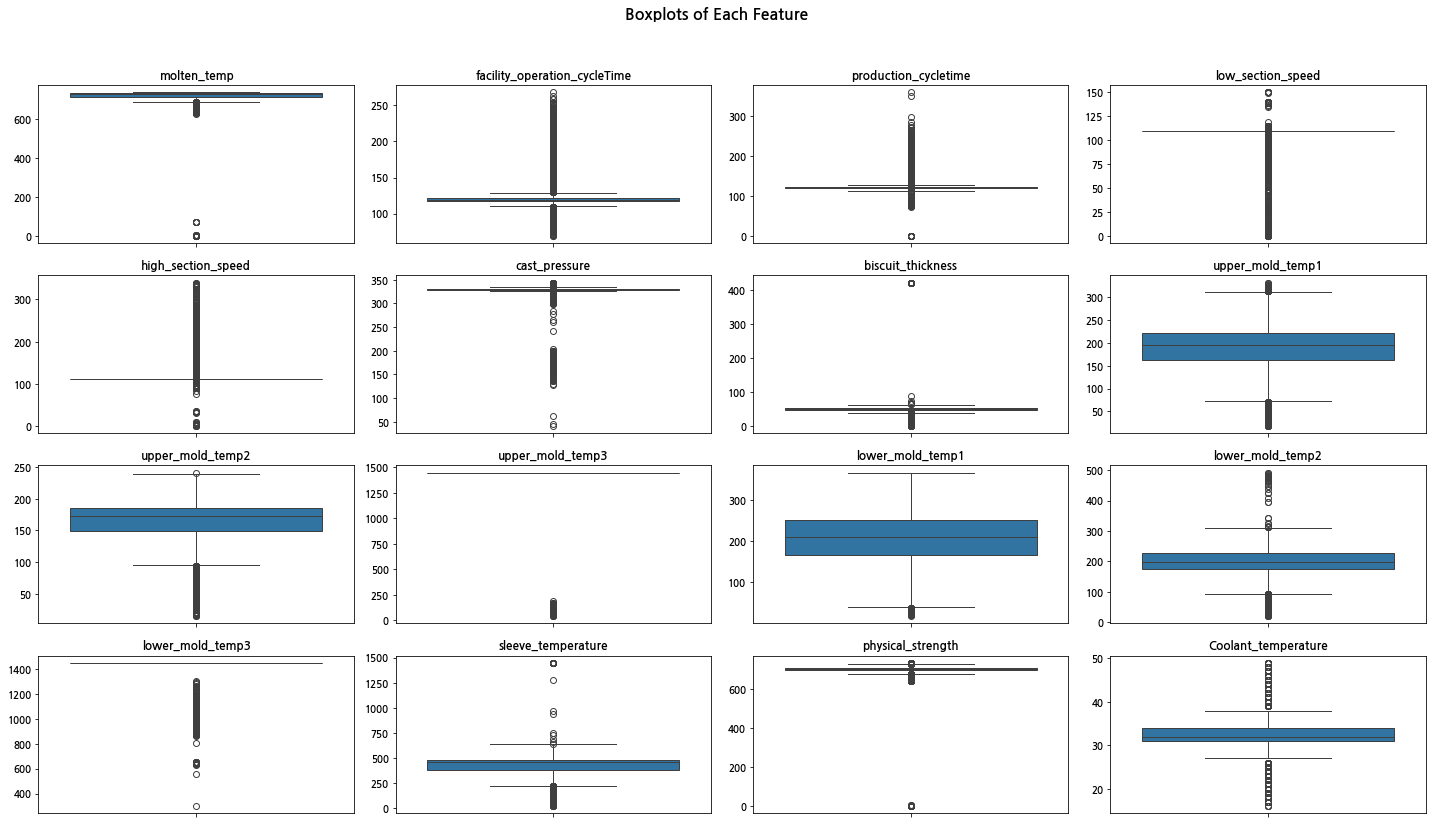

In [35]:
# 3x6 형태로 Subplot 생성
fig, axes = plt.subplots(4, 4, figsize=(20, 12))
fig.suptitle('Boxplots of Each Feature', fontsize=16)

# 컬럼 목록
columns = ['molten_temp', 'facility_operation_cycleTime', 'production_cycletime',
       'low_section_speed', 'high_section_speed', 'cast_pressure',
       'biscuit_thickness', 'upper_mold_temp1', 'upper_mold_temp2',
       'upper_mold_temp3', 'lower_mold_temp1', 'lower_mold_temp2',
       'lower_mold_temp3', 'sleeve_temperature', 'physical_strength',
       'Coolant_temperature']

# 각 컬럼에 대해 Boxplot 그리기
for i, col in enumerate(columns):
    row = i // 4
    col_pos = i % 4
    sns.boxplot(data=data1, y=col, ax=axes[row, col_pos])
    axes[row, col_pos].set_title(col)
    axes[row, col_pos].set_xlabel('')
    axes[row, col_pos].set_ylabel('')

# 레이아웃 조정
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [36]:
data1.skew()

Unnamed: 0                      -0.047427
count                            0.084422
molten_temp                    -13.215627
facility_operation_cycleTime     5.287995
production_cycletime             4.913561
low_section_speed               -7.523667
high_section_speed               9.853453
cast_pressure                   -5.774660
biscuit_thickness               19.462275
upper_mold_temp1                -0.566700
upper_mold_temp2                -0.617773
upper_mold_temp3                -2.668133
lower_mold_temp1                -0.278282
lower_mold_temp2                 0.045641
lower_mold_temp3                -7.621697
sleeve_temperature              -0.708226
physical_strength              -18.526159
Coolant_temperature             -0.039995
EMS_operation_time              -1.285122
passorfail                       4.454997
mold_code                       -0.134562
group                           -0.106836
dtype: float64

# 카테고리 데이터 선정

# 이상치 관련 - 주요변수만

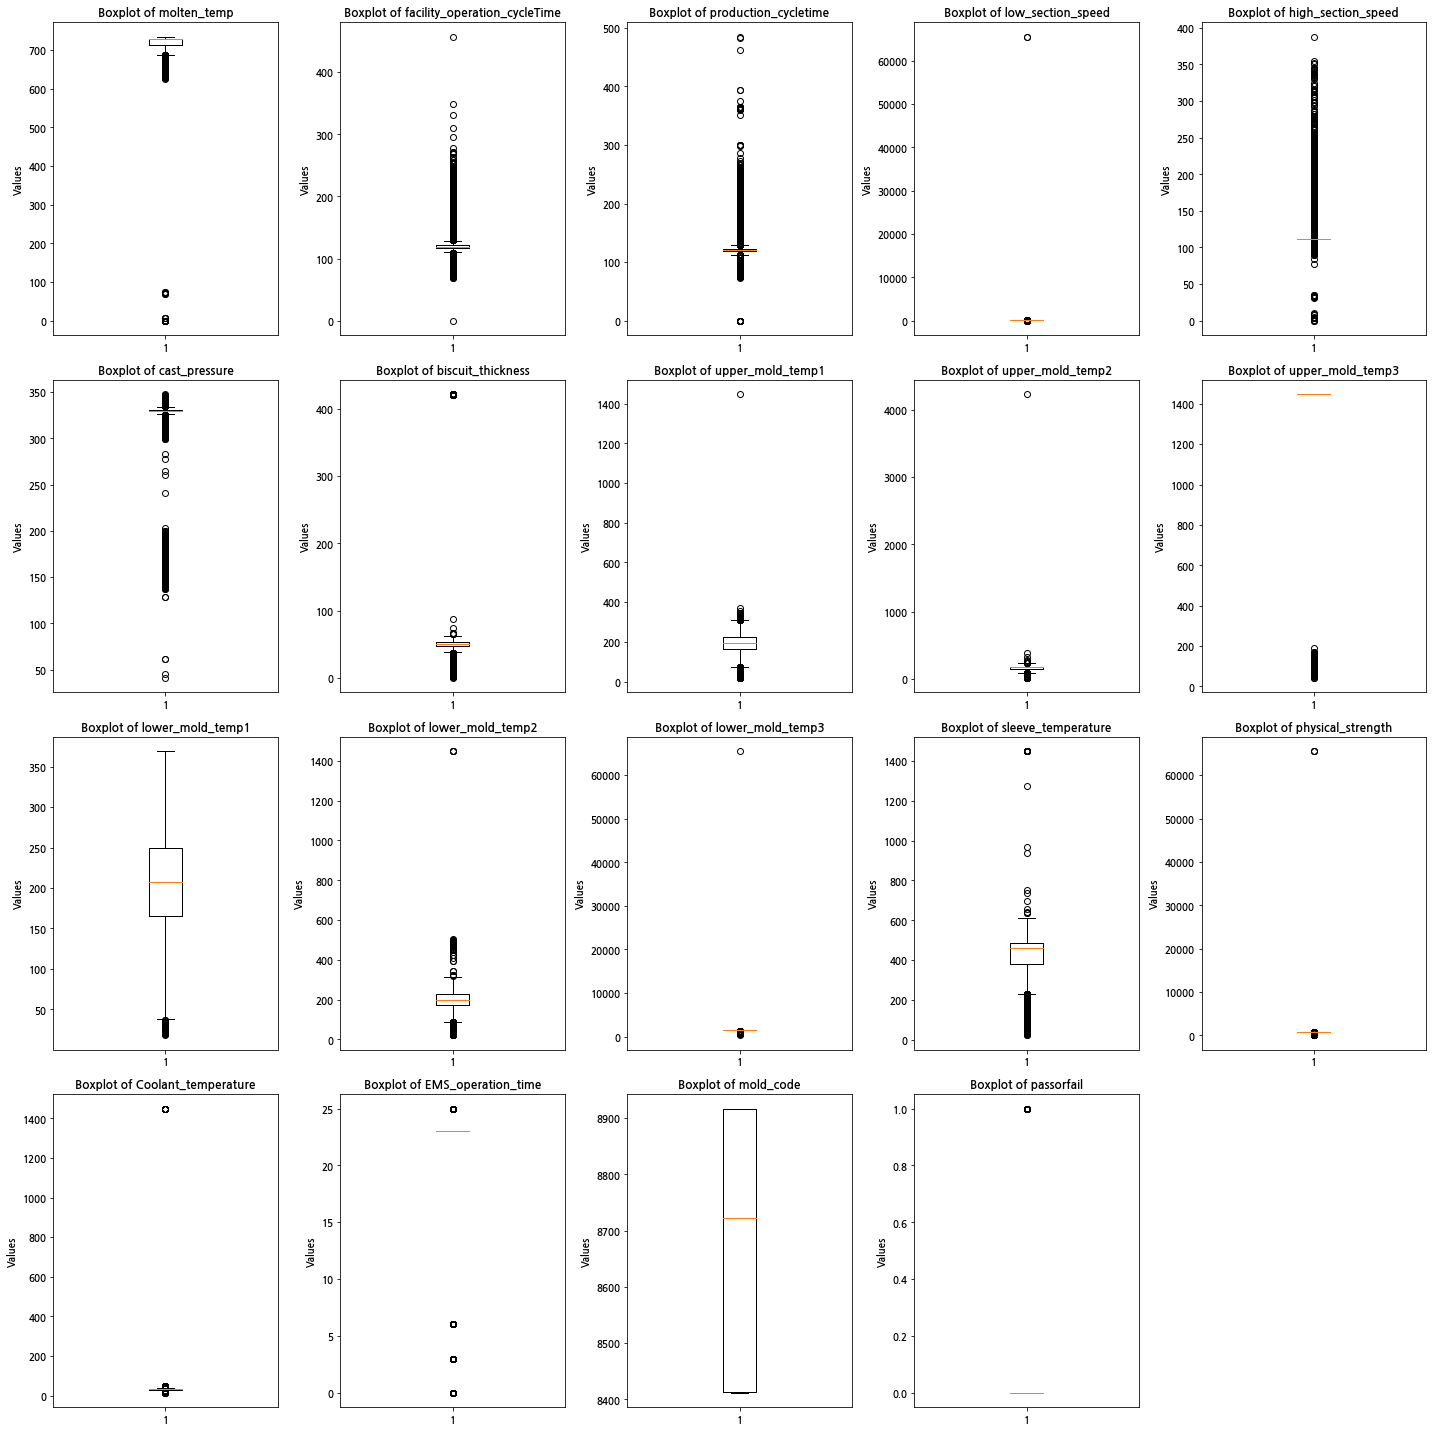

In [ ]:
# Select only numeric columns from the DataFrame
numeric_cols = df.select_dtypes(include=['float64', 'int64'])


# Set up the grid dimensions: 3 columns and as many rows as needed
num_columns = 5
num_plots = len(numeric_cols.columns)
num_rows = math.ceil(num_plots / num_columns)

# Create the subplots with a grid
plt.figure(figsize=(20, 5 * num_rows))

for i, col in enumerate(numeric_cols.columns, 1):
    plt.subplot(num_rows, num_columns, i)
    plt.boxplot(numeric_cols[col].dropna())  # Drop NaN values to avoid errors
    plt.title(f"Boxplot of {col}")
    plt.ylabel("Values")

plt.tight_layout()
plt.show()

# train, val, test 데이터 분할 분포 확인

In [38]:
train = pd.read_csv('casting/data/processed_data/train.csv')
valid = pd.read_csv('casting/data/processed_data/valid.csv')
test = pd.read_csv('casting/data/processed_data/test.csv')

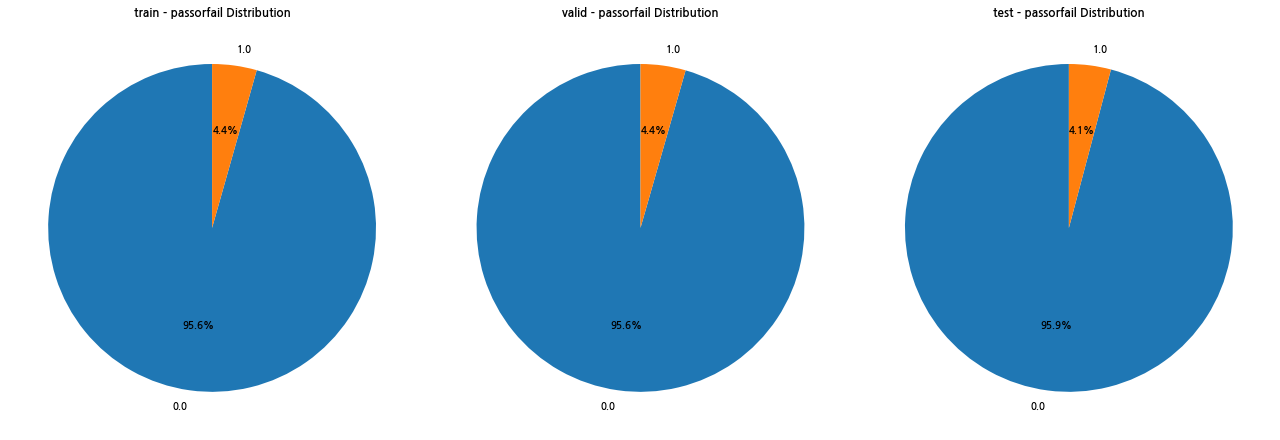

In [39]:
dist1 = train['passorfail'].value_counts()
dist2 = valid['passorfail'].value_counts()
dist3 = test['passorfail'].value_counts()

# Plot pie charts for each dataset
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Dataset 1
axes[0].pie(dist1, labels=dist1.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title("train - passorfail Distribution")

# Dataset 2
axes[1].pie(dist2, labels=dist2.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title("valid - passorfail Distribution")

# Dataset 3
axes[2].pie(dist3, labels=dist3.index, autopct='%1.1f%%', startangle=90)
axes[2].set_title("test - passorfail Distribution")

plt.tight_layout()
plt.show()

# 디지털 트윈 모델 후처리

## EXT 모델의 오분류
1. 오분류 데이터들의 proba 확인 -> Threshold 변경을 통해 오분류를 개선시킬 수 있는가? 
2. feature importance -> 어떤 feature 가 모델의 예측에 영향을 미치는가 ?  
3. feature distribution -> 시각적으로 어떤 feature들이 정상분류데이터들과 차이를 보이는가? 
4. SHAP 
5. ICE, PDP 


cuda


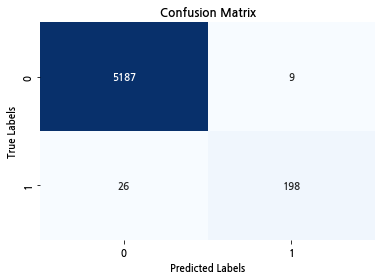

F1 Score: 0.9188
accuracy_score: 0.9935
precision_score: 0.9565
recall_score: 0.8839


In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

from casting.configuration import paths, columns, params, optimization
from casting.preprocessing import (
                                   drop_null, 
                                   split_by_dbscan,
                                   remove_outlier,
                                   save_scaler,
                                   save_label_encoding)
from casting.utils import load_data
from casting.optimizer import BayesianOptimizer

from casting.trainner import train_xgboost, train_lightgbm, train_extra_trees, train_tabnet, train_FTT, FttDataloader
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix


from torch.utils.data import DataLoader
import torch

from matplotlib import font_manager, rc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pd.set_option('display.max_columns', None) ## 모든 열을 출력한다

font_manager.fontManager.addfont('NanumGothic-Bold.ttf')
plt.rc('font', family='NanumGothic')

data_origin = pd.read_csv(paths.origin_path, encoding = 'euc-kr')
data = data_origin[columns.use_columns]


## null 값 제외
data = drop_null(data).reset_index(drop=True)
## 이상치 제거
data = remove_outlier(data)


if params.model_name == 'FTT':
    ## 스케일러 생성
    save_scaler(data, 
                columns.numeric_columns, 
                columns.target_column,
                paths.X_scaler_path,
                paths.y_scaler_path
                )
    ## 카테고리 컬럼 처리를 위한 라벨 인코딩
    save_label_encoding(data, columns.category_columns, paths.label_encoding_path)

    split_by_dbscan(data, 'casting/data/scaled_data/')
else :
    ## 데이터 분리
    split_by_dbscan(data, 'casting/data/processed_data/')


# EXT 사용
train, valid, test = load_data(params.model_name)

if params.model_name == 'LGBM' :
    model = train_lightgbm(train, valid)
elif params.model_name == 'XGB' :
    model = train_xgboost(train, valid)
elif params.model_name == 'EXT' :
    model = train_extra_trees(train, valid)
elif params.model_name == 'TABNET' :
    model = train_tabnet(train, valid)
## GPU 환경 필수
elif params.model_name == 'FTT' :
    model = train_FTT(train, valid)


# 혼동 행렬 계산

## FTT 모델일때 inference
if params.model_name == 'FTT' :
    test_data = FttDataloader(test)
    test_loader = DataLoader(test_data, batch_size=len(test), shuffle=False)

    model.to(device)
    model.eval()
    all_pred = []
    all_y = []
    x_samples = []
    with torch.no_grad():
        cul_loss = 0  # SE
        count = 0
        for batch, (x_categ, x_numer, y) in enumerate(test_loader):
            x_categ, x_numer, y = x_categ.to(device), x_numer.to(device), y.to(device)
            # 예측 오류 계산
            pred = model(x_categ, x_numer)
            pred = pred.cpu().detach().numpy()
            y = y.cpu().detach().numpy()
            all_pred.extend(pred)
            all_y.extend(y)

    all_pred = np.array(all_pred)
    all_y = np.array(all_y)

    y_test = pd.DataFrame(np.array(all_y)) 
    y_pred = pd.DataFrame(np.array(all_pred)).round(1).astype(int)
## 그외 모델일때
else :

    X_test, y_test = test[columns.input_columns], test[columns.target_column]
    

    y_pred = model.predict(X_test.values)
    test_cm = confusion_matrix(y_test, y_pred)

    # 혼동 행렬 계산
    cm = confusion_matrix(y_test, y_pred)

    # 혼동 행렬 시각화
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# 점수 계산
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

acc = accuracy_score(y_test, y_pred)
print(f'accuracy_score: {acc:.4f}')

ps = precision_score(y_test, y_pred)
print(f'precision_score: {ps:.4f}')

rs = recall_score(y_test, y_pred)
print(f'recall_score: {rs:.4f}')

In [5]:
test['y_pred'] = y_pred
test

,molten_temp,facility_operation_cycleTime,production_cycletime,low_section_speed,high_section_speed,cast_pressure,biscuit_thickness,upper_mold_temp1,upper_mold_temp2,upper_mold_temp3,lower_mold_temp1,lower_mold_temp2,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,mold_code,passorfail,y_pred
0,719.0,121,122,100.0,101.0,332.0,39.0,128.0,118.0,1449.0,114.0,199.0,1449.0,420.0,705.0,29.0,23,8722,1.0,1.0
1,727.0,122,140,110.0,111.0,329.0,52.0,206.0,218.0,1449.0,277.0,254.0,1449.0,382.0,693.0,31.0,23,8413,0.0,0.0
2,728.0,118,120,110.0,111.0,173.0,45.0,109.0,137.0,1449.0,156.0,128.0,1449.0,313.0,707.0,27.0,23,8917,1.0,1.0
3,716.0,123,123,110.0,112.0,331.0,54.0,107.0,197.0,114.0,148.0,212.0,1449.0,476.0,704.0,31.0,23,8573,0.0,0.0
4,731.0,126,82,95.0,103.0,157.0,43.0,138.0,144.0,1449.0,128.0,106.0,1449.0,484.0,705.0,27.0,23,8722,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5415,733.0,122,122,100.0,101.0,333.0,54.0,230.0,216.0,1449.0,228.0,210.0,1449.0,297.0,718.0,34.0,0,8917,0.0,0.0
5416,729.0,122,123,100.0,101.0,332.0,50.0,223.0,215.0,1449.0,242.0,206.0,1449.0,277.0,706.0,33.0,0,8917,0.0,0.0
5417,728.0,122,123,100.0,102.0,332.0,56.0,226.0,214.0,1449.0,236.0,206.0,1449.0,279.0,728.0,34.0,0,8917,0.0,0.0
5418,733.0,119,121,100.0,103.0,332.0,55.0,75.0,164.0,1449.0,222.0,193.0,1449.0,296.0,722.0,30.0,0,8917,0.0,0.0


In [6]:
correct = test[test['passorfail'] == test['y_pred']]
error = test[test['passorfail'] != test['y_pred']]
fp = error[error['y_pred'] == 1] #원래는 양품, 불량으로 예측 
fn = error[error['y_pred'] == 0] #원래는 불량. 양품으로 예측 

In [7]:
fp['mold_code'].value_counts()

mold_code
8722    5
8917    2
8413    1
8600    1
Name: count, dtype: int64

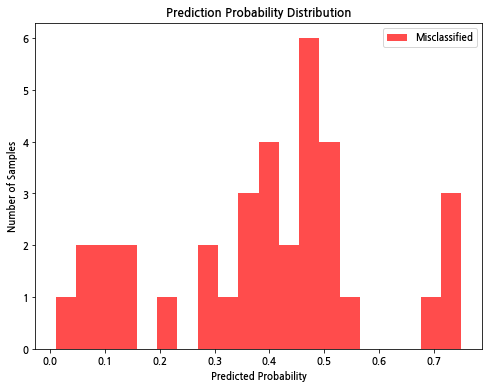

In [8]:
y_proba = model.predict_proba(X_test)[:, 1]
y_proba



# 오분류된 샘플의 예측 확률 확인
misclassified_proba = y_proba[error.index]
plt.figure(figsize=(8, 6))
plt.hist(misclassified_proba, bins=20, color='red', alpha=0.7, label='Misclassified')
#plt.hist(y_proba[correct.index], bins=20, color='blue', alpha=0.7, label='Correctly Classified')
plt.title('Prediction Probability Distribution')
plt.xlabel('Predicted Probability')
plt.ylabel('Number of Samples')
plt.legend()
plt.show()

Text(0, 0.5, 'Features')

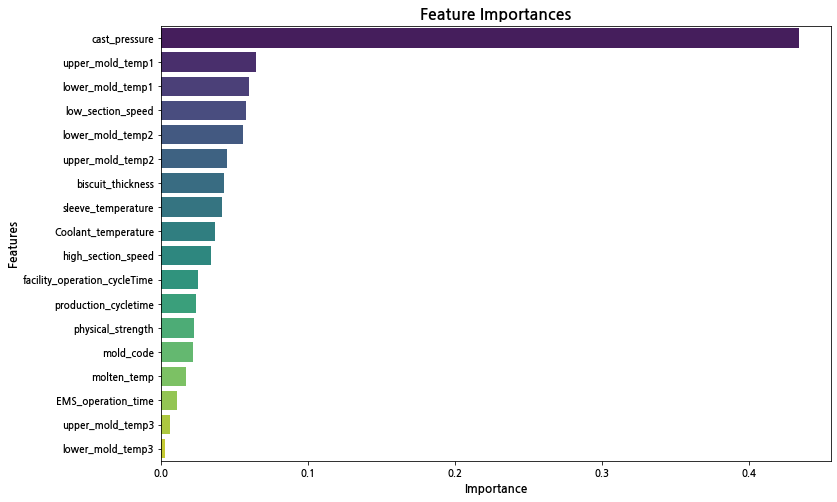

In [ ]:
## feature importance 확인 
feature_importances = pd.Series(model.feature_importances_, index=columns.input_columns)
feat_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=feat_importances.values, y=feat_importances.index, palette="viridis")
plt.title('Feature Importances', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)


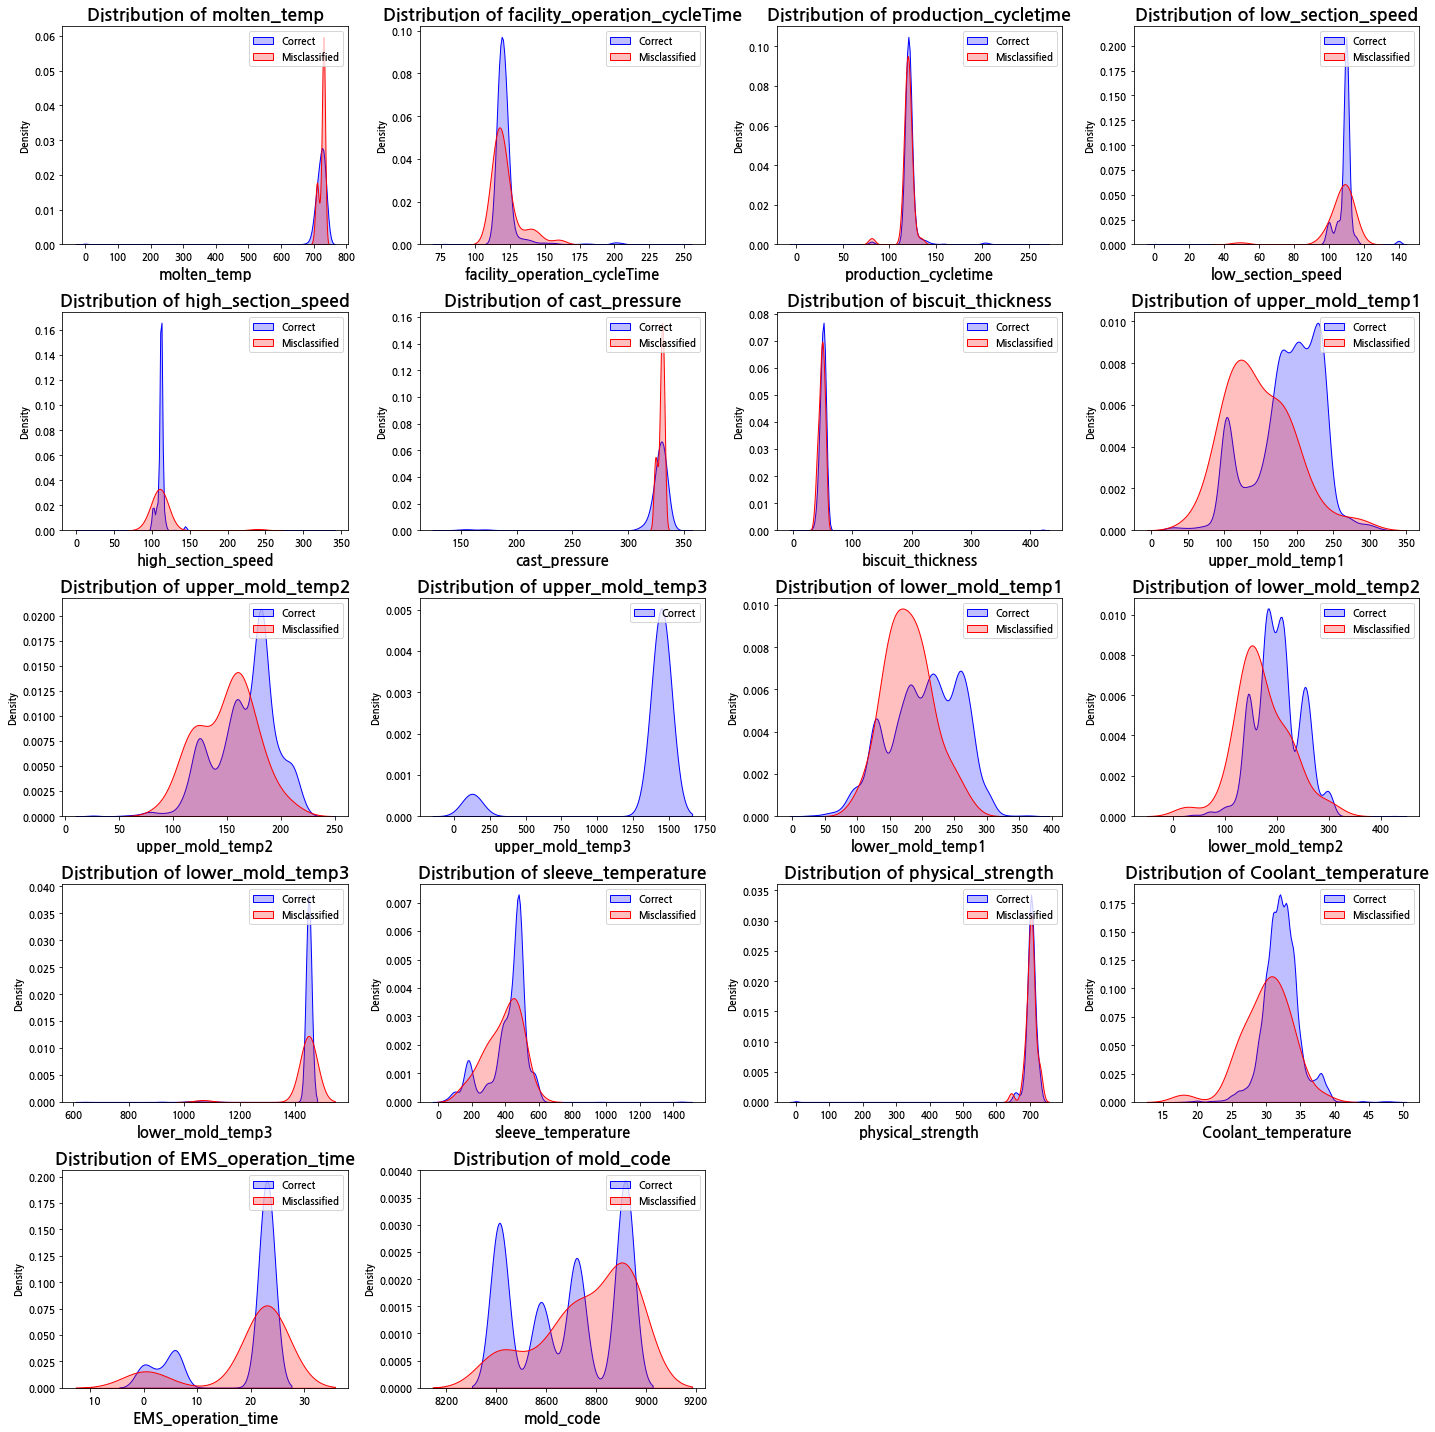

In [ ]:
## Feature 분포 확인 
features = X_test.columns.tolist()  

n_features = len(features)
n_cols = 4  
n_rows = math.ceil(n_features / n_cols)  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten() 

for idx, feature in enumerate(features):
    ax = axes[idx]
    sns.kdeplot(correct[feature], label='Correct', shade=True, color='blue', ax=ax)
    sns.kdeplot(error[feature], label='Misclassified', shade=True, color='red', ax=ax)
    ax.set_title(f'Distribution of {feature}', fontsize = 18)
    ax.set_xlabel(feature, fontsize = 15)
    ax.legend()

for idx in range(n_features, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


In [ ]:
## 보여지는 분포말고도 ttest 상으로도 유의미한 차이를 갖는가? 
selected_feat = ['lower_mold_temp2', 'cast_pressure', 'upper_mold_temp2']


for feature in selected_feat:
    error_values = error[feature]
    correct_values = correct[feature]
    
    # t-검정 수행
    t_stat, p_value = ttest_ind(error_values, correct_values, equal_var=False)
    
    print(f"Feature: {feature}, p-value: {p_value}")

Feature: lower_mold_temp2, p-value: 0.0017604145367501036
Feature: cast_pressure, p-value: 4.66988433718993e-12
Feature: upper_mold_temp2, p-value: 0.0006800905650280502


In [ ]:
# SHAP 값 계산
explainer = shap.TreeExplainer(model, model_output = 'raw')
shap_values = explainer.shap_values(fp[X_test.columns])  # X는 전체 데이터


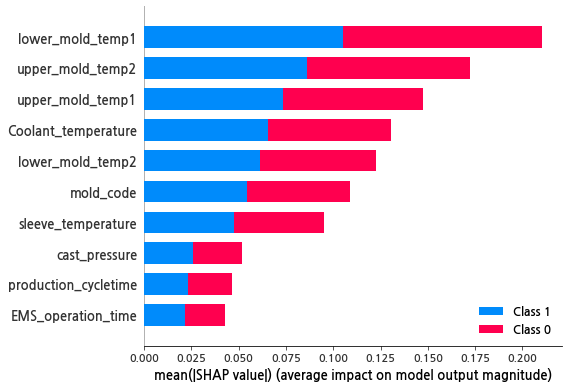

In [26]:
# FP 샘플의 SHAP Summary Plot
# fp_shap = shap_values[fp.index]

shap.summary_plot(shap_values, X_test.iloc[fp.index], plot_type='bar', max_display=10)

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

(<Figure size 4800x2700 with 3 Axes>,
 {'title_axes': <Axes: >,
  'line_axes': [<Axes: ylabel='centered'>],
  'dist_axes': [<Axes: title={'center': 'distribution of data points'}, xlabel='$\\bf{lower\\_mold\\_temp1}$ (value)'>]})

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


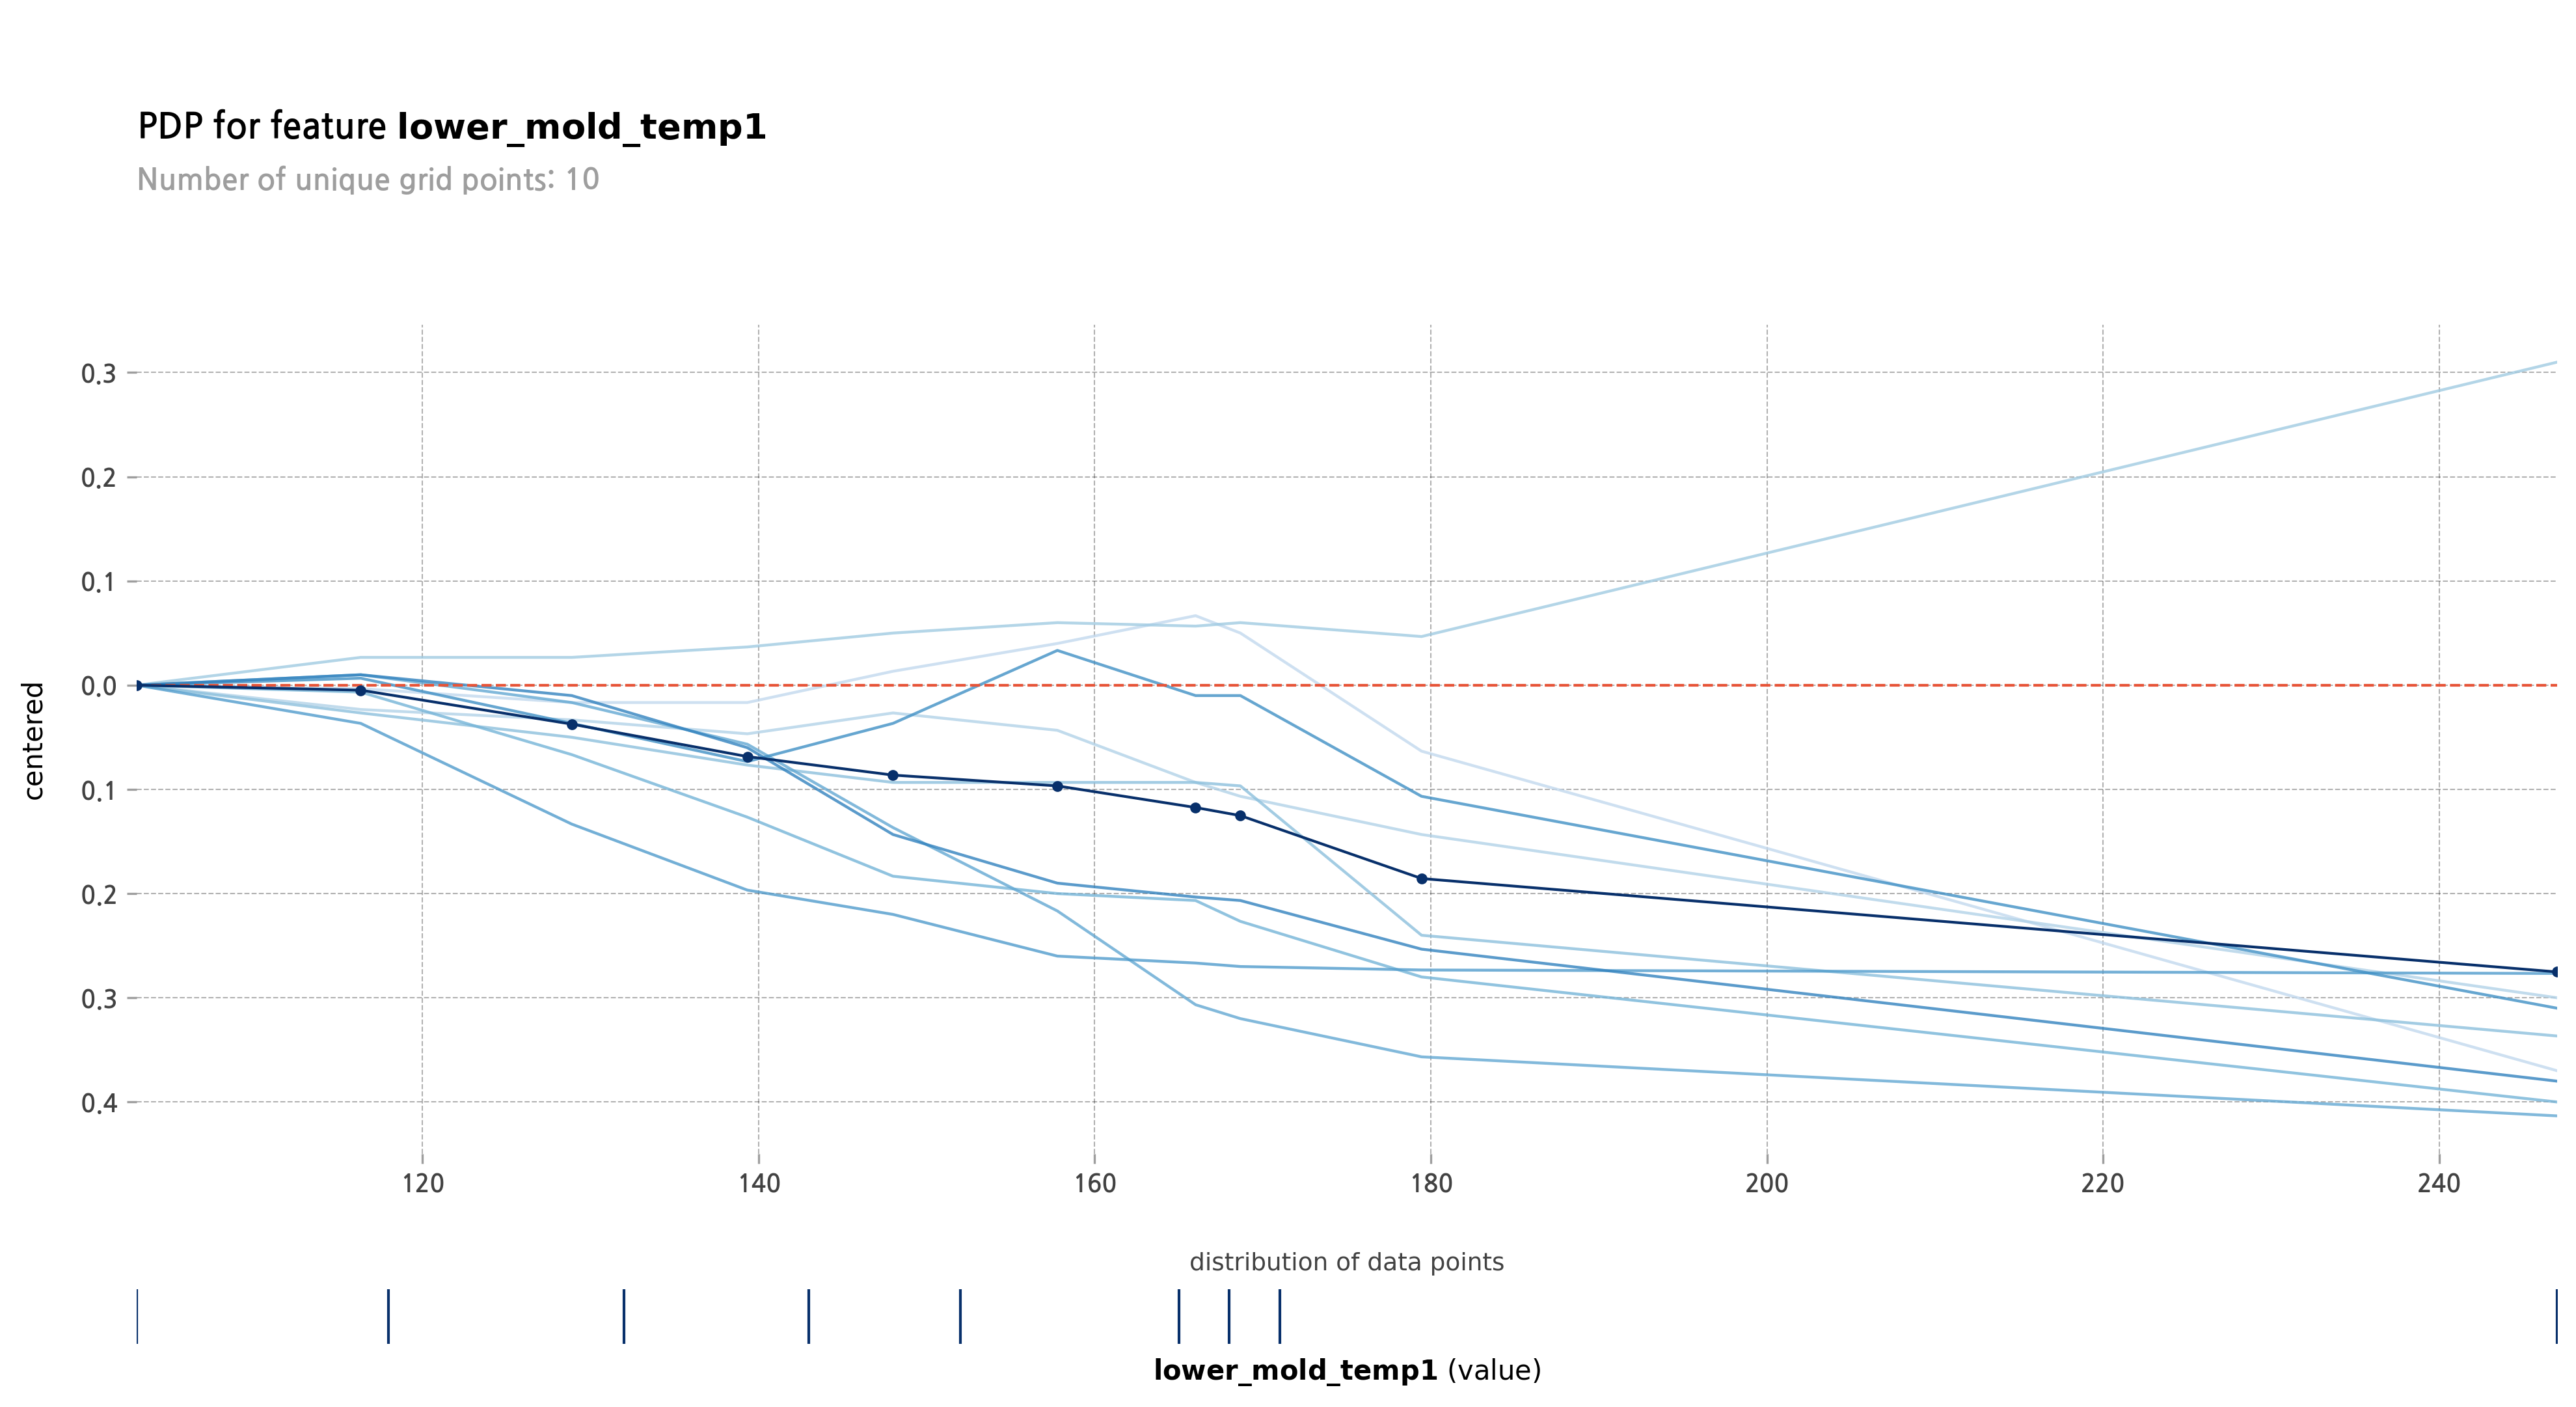

In [ ]:
# 그릴 특성 리스트
feature_names = ['lower_mold_temp1', 'lower_mold_temp2', 'sleeve_temperature', 'upper_mold_temp1', 'low_section_speed']
selected_feature = 'lower_mold_temp1'
# 각 특성에 대해 PDP를 그립니다.
pdp_iso = PDPIsolate(
        model=model,
        df = fp, 
        feature_name='lower_mold_temp1',
        feature = selected_feature,
        model_features = X_test.columns
    )
pdp_iso.plot(engine = 'matplotlib', plot_pts_dist = True, show_percentile = True, plot_lines = True)


# 번외
## 날씨가 불량품에 미치는 영향

In [ ]:
df = pd.read_csv(paths.origin_path, encoding = 'euc-kr', index_col = 0)

### 온도를 나타내는 columns 
1. molten_temp
2. upper_mold_temp1
3. upper_mold_temp2
4. upper_mold_temp3
5. lower_mold_temp1
6. lower_mold_temp2
7. lower_mold_temp3
8. sleeve_temperature
9. Coolant_temperature


### target_cols 
- passorfail
 

In [29]:
df.columns

Index(['line', 'name', 'mold_name', 'time', 'date', 'count', 'working',
       'emergency_stop', 'molten_temp', 'facility_operation_cycleTime',
       'production_cycletime', 'low_section_speed', 'high_section_speed',
       'molten_volume', 'cast_pressure', 'biscuit_thickness',
       'upper_mold_temp1', 'upper_mold_temp2', 'upper_mold_temp3',
       'lower_mold_temp1', 'lower_mold_temp2', 'lower_mold_temp3',
       'sleeve_temperature', 'physical_strength', 'Coolant_temperature',
       'EMS_operation_time', 'registration_time', 'passorfail',
       'tryshot_signal', 'mold_code', 'heating_furnace'],
      dtype='object')

In [30]:
df['sleeve_temperature'].describe()

count    92014.000000
mean       418.613255
std        115.831898
min         23.000000
25%        383.000000
50%        461.000000
75%        484.000000
max       1449.000000
Name: sleeve_temperature, dtype: float64

In [34]:
df['datetime'] = pd.to_datetime(df['time'] + ' ' + df['date'])
df['datetime'].describe()

count                            92015
mean     2019-02-17 08:40:53.524588288
min                2019-01-02 16:45:06
25%         2019-01-28 03:26:53.500000
50%                2019-02-20 12:35:43
75%         2019-03-09 03:38:58.500000
max                2019-03-31 23:59:48
Name: datetime, dtype: object

In [31]:
target_col = 'passorfail'
fail = df[df[target_col] == 1]
fail

,line,name,mold_name,time,date,count,working,emergency_stop,molten_temp,facility_operation_cycleTime,production_cycletime,low_section_speed,high_section_speed,molten_volume,cast_pressure,biscuit_thickness,upper_mold_temp1,upper_mold_temp2,upper_mold_temp3,lower_mold_temp1,lower_mold_temp2,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,registration_time,passorfail,tryshot_signal,mold_code,heating_furnace
22,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019.1.2,17:27:28,73,가동,ON,731.0,119,120,109.0,125.0,74.0,177.0,48.0,24.0,33.0,1449.0,30.0,273.0,1449.0,479.0,708.0,35.0,23,2019.1.2 17:27,1.0,NaN,8722,NaN
24,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019.1.2,17:29:32,1,가동,ON,731.0,119,123,109.0,112.0,72.0,176.0,49.0,26.0,55.0,1449.0,30.0,323.0,1449.0,513.0,700.0,35.0,23,2019.1.2 17:29,1.0,NaN,8722,NaN
26,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019.1.2,17:31:41,2,가동,ON,731.0,119,124,109.0,112.0,72.0,331.0,47.0,31.0,65.0,1449.0,30.0,343.0,1449.0,531.0,708.0,34.0,23,2019.1.2 17:31,1.0,NaN,8722,NaN
28,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019.1.2,17:33:39,3,가동,ON,731.0,120,124,110.0,112.0,71.0,331.0,46.0,36.0,73.0,1449.0,31.0,343.0,1449.0,544.0,707.0,34.0,23,2019.1.2 17:33,1.0,NaN,8722,NaN
30,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019.1.2,17:35:43,4,가동,ON,730.0,120,124,110.0,112.0,71.0,331.0,50.0,41.0,78.0,1449.0,32.0,394.0,1449.0,545.0,706.0,34.0,23,2019.1.2 17:35,1.0,NaN,8722,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91973,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019.3.31,22:34:55,34,가동,ON,731.0,156,127,99.0,104.0,NaN,333.0,50.0,58.0,147.0,1449.0,118.0,134.0,1449.0,214.0,702.0,29.0,0,2019.3.31 22:34,1.0,D,8917,B
91974,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019.3.31,22:37:12,35,가동,ON,730.0,127,137,100.0,104.0,NaN,332.0,52.0,61.0,149.0,1449.0,142.0,146.0,1449.0,241.0,710.0,29.0,0,2019.3.31 22:37,1.0,D,8917,B
91975,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019.3.31,22:39:09,36,가동,ON,729.0,127,117,100.0,101.0,NaN,153.0,50.0,68.0,151.0,1449.0,165.0,161.0,1449.0,257.0,713.0,29.0,0,2019.3.31 22:39,1.0,D,8917,B
91976,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019.3.31,22:41:05,37,가동,ON,729.0,127,116,100.0,101.0,NaN,149.0,49.0,72.0,153.0,1449.0,174.0,165.0,1449.0,261.0,717.0,29.0,0,2019.3.31 22:41,1.0,D,8917,B


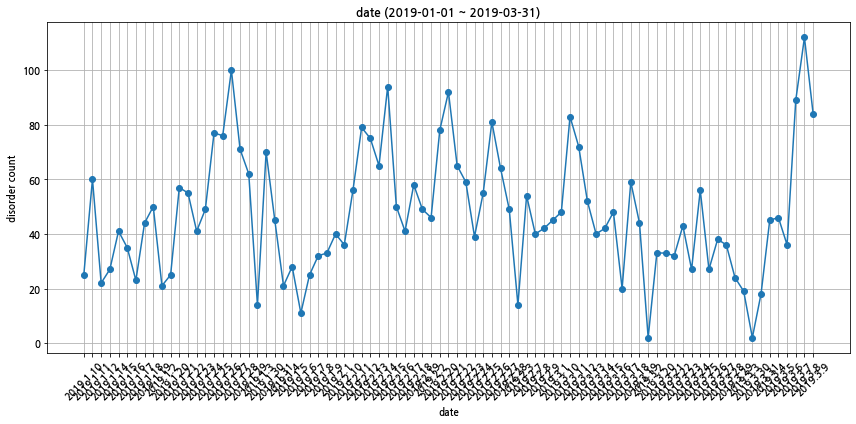

In [38]:
daily = fail.groupby(fail['time']).size()
plt.figure(figsize=(12, 6))
plt.plot(daily.index, daily.values, marker='o', linestyle='-')
plt.title("date (2019-01-01 ~ 2019-03-31)")
plt.xlabel("date")
plt.ylabel("disorder count")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## 온도 관련 외부 데이터 분석

In [39]:
rain = pd.read_csv(paths.external_rain_path, encoding = 'euc-kr')
humi = pd.read_csv(paths.external_humi_path, encoding = 'euc-kr')
temp = pd.read_csv(paths.external_temp_path, encoding = 'euc-kr')

In [40]:
rain['일시'] = pd.to_datetime(rain['일시'])
rain = rain.dropna(subset = '일시')
rain.columns

Index(['\t\t지역번호', '지역명', '일시', '평균기온(℃)', '평균최고기온(℃)', '최고기온(℃)', '최고기온관측지점',
       '평균최저기온(℃)', '최저기온(℃)', '최저기온관측지점일교차', 'Unnamed: 10', 'Unnamed: 11',
       'Unnamed: 12'],
      dtype='object')

In [41]:
rain.columns

Index(['\t\t지역번호', '지역명', '일시', '평균기온(℃)', '평균최고기온(℃)', '최고기온(℃)', '최고기온관측지점',
       '평균최저기온(℃)', '최저기온(℃)', '최저기온관측지점일교차', 'Unnamed: 10', 'Unnamed: 11',
       'Unnamed: 12'],
      dtype='object')

In [42]:
humi['일시'] = pd.to_datetime(humi['일시'])
humi = humi.dropna(subset = '일시')
humi

,\t\t지역번호,지역명,일시,평균습도(%rh),최저습도(%rh),최저습도지점,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,0,전국,2019-03-31,48.0,17.0,정읍,광양시,거제,NaN
1,0,전국,2019-03-30,67.0,13.0,서귀포,NaN,NaN,NaN
2,0,전국,2019-03-29,54.0,12.0,강진군,NaN,NaN,NaN
3,0,전국,2019-03-28,63.0,10.0,양평,NaN,NaN,NaN
4,0,전국,2019-03-27,57.0,5.0,구미,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
85,0,전국,2019-01-05,49.0,9.0,밀양,NaN,NaN,NaN
86,0,전국,2019-01-04,53.0,8.0,구미,NaN,NaN,NaN
87,0,전국,2019-01-03,48.0,6.0,거제,NaN,NaN,NaN
88,0,전국,2019-01-02,53.0,7.0,북강릉,NaN,NaN,NaN


In [43]:
temp['일시'] = pd.to_datetime(temp['일시'])
temp = temp.dropna(subset = '일시')
temp

,\t\t지역번호,지역명,일시,평균일강수량(mm),최다일강수량(mm),최다강수량지점,1시간최다강수량(mm),1시간최다강수량지점일교차,Unnamed: 8
0,0,전국,2019-03-31,0.2,12.0,울릉도,NaN,NaN,NaN
1,0,전국,2019-03-30,3.0,8.0,청송군,NaN,NaN,NaN
2,0,전국,2019-03-29,0.0,24.6,울릉도,NaN,NaN,NaN
3,0,전국,2019-03-28,0.6,12.9,북강릉,NaN,NaN,NaN
4,0,전국,2019-03-27,0.1,3.3,속초,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
85,0,전국,2019-01-05,0.0,5.9,울릉도,NaN,NaN,NaN
86,0,전국,2019-01-04,0.0,3.2,서귀포,NaN,NaN,NaN
87,0,전국,2019-01-03,0.0,NaN,NaN,NaN,NaN,NaN
88,0,전국,2019-01-02,0.0,0.0,울릉도,목포,흑산도,순천


In [44]:
temp.columns

Index(['\t\t지역번호', '지역명', '일시', '평균일강수량(mm)', '최다일강수량(mm)', '최다강수량지점',
       '1시간최다강수량(mm)', '1시간최다강수량지점일교차', 'Unnamed: 8'],
      dtype='object')

In [45]:
temp_df = rain[['일시', '평균기온(℃)', '평균최고기온(℃)', '평균최저기온(℃)']]
humi_df = humi[['일시', '평균습도(%rh)', '최저습도(%rh)']]
rain_df = temp[['일시', '평균일강수량(mm)']]

In [46]:
df1 = temp_df.merge(humi_df)
df1

,일시,평균기온(℃),평균최고기온(℃),평균최저기온(℃),평균습도(%rh),최저습도(%rh)
0,2019-03-31,5.4,9.2,2.3,48.0,17.0
1,2019-03-30,7.2,12.2,3.7,67.0,13.0
2,2019-03-29,10.6,17.0,5,54.0,12.0
3,2019-03-28,10.6,16.1,6.6,63.0,10.0
4,2019-03-27,12.8,19.9,4.8,57.0,5.0
...,...,...,...,...,...,...
85,2019-01-05,0.2,5.3,-4.6,49.0,9.0
86,2019-01-04,-0.7,5.3,-7.3,53.0,8.0
87,2019-01-03,-2.1,5.0,-7.7,48.0,6.0
88,2019-01-02,-2.5,3.2,-7,53.0,7.0


In [47]:
df2 = df1.merge(rain_df)

In [48]:
df2.sort_values(by = '일시', inplace = True)
df2 = df2[df2['일시']!= '2019-01-01']
df2

,일시,평균기온(℃),평균최고기온(℃),평균최저기온(℃),평균습도(%rh),최저습도(%rh),평균일강수량(mm)
88,2019-01-02,-2.5,3.2,-7,53.0,7.0,0.0
87,2019-01-03,-2.1,5.0,-7.7,48.0,6.0,0.0
86,2019-01-04,-0.7,5.3,-7.3,53.0,8.0,0.0
85,2019-01-05,0.2,5.3,-4.6,49.0,9.0,0.0
84,2019-01-06,-1.3,5.7,-6.1,46.0,6.0,0.0
...,...,...,...,...,...,...,...
4,2019-03-27,12.8,19.9,4.8,57.0,5.0,0.1
3,2019-03-28,10.6,16.1,6.6,63.0,10.0,0.6
2,2019-03-29,10.6,17.0,5,54.0,12.0,0.0
1,2019-03-30,7.2,12.2,3.7,67.0,13.0,3.0


In [49]:
df2.columns = ['일시','평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균일강수량']


In [50]:
df2.reset_index(inplace = True, drop = True)
df2.to_csv('weather.csv')

In [51]:
daily_df = daily.reset_index()
daily_df.columns = ['time', 'count']
daily_df

,time,count
0,2019.1.10,25
1,2019.1.11,60
2,2019.1.12,22
3,2019.1.14,27
4,2019.1.15,41
...,...,...
80,2019.3.5,46
81,2019.3.6,36
82,2019.3.7,89
83,2019.3.8,112


In [52]:
# '일시'와 'time' 컬럼의 형식이 다를 경우 datetime 형식으로 변환
df2['일시'] = pd.to_datetime(df2['일시'])
daily_df['time'] = pd.to_datetime(daily_df['time'])

# 두 데이터프레임을 '일시'와 'time'을 기준으로 병합 (left join 사용)
merged_df = pd.merge(df2, daily_df, left_on='일시', right_on='time', how='left')

# 'count' 컬럼에서 NaN 값을 0으로 채움
merged_df['count'] = merged_df['count'].fillna(0)

# 필요에 따라 'time' 컬럼을 제거
merged_df = merged_df.drop(columns=['time'])


In [53]:
merged_df

,일시,평균기온,최고기온,최저기온,평균습도,최저습도,평균일강수량,count
0,2019-01-02,-2.5,3.2,-7,53.0,7.0,0.0,21.0
1,2019-01-03,-2.1,5.0,-7.7,48.0,6.0,0.0,14.0
2,2019-01-04,-0.7,5.3,-7.3,53.0,8.0,0.0,21.0
3,2019-01-05,0.2,5.3,-4.6,49.0,9.0,0.0,28.0
4,2019-01-06,-1.3,5.7,-6.1,46.0,6.0,0.0,11.0
...,...,...,...,...,...,...,...,...
84,2019-03-27,12.8,19.9,4.8,57.0,5.0,0.1,38.0
85,2019-03-28,10.6,16.1,6.6,63.0,10.0,0.6,36.0
86,2019-03-29,10.6,17.0,5,54.0,12.0,0.0,24.0
87,2019-03-30,7.2,12.2,3.7,67.0,13.0,3.0,2.0


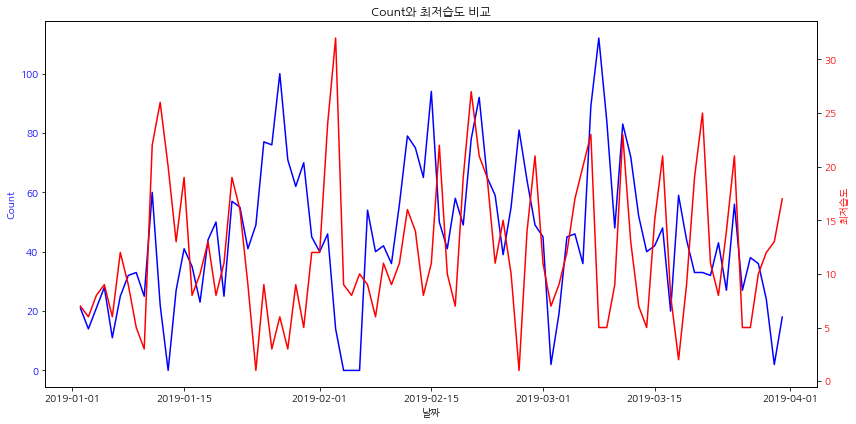

In [ ]:
# 날짜 정보를 x축으로, count와 평균기온을 각각 y축에 시각화
fig, ax1 = plt.subplots(figsize=(12, 6))

# 첫 번째 y축: count
ax1.plot(merged_df['일시'], merged_df['count'], color='b', label='Count')
ax1.set_xlabel('날짜')
ax1.set_ylabel('Count', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# 두 번째 y축: 평균기온
ax2 = ax1.twinx()
ax2.plot(merged_df['일시'], merged_df['최저습도'], color='r', label='최저습도')
ax2.set_ylabel('최저습도', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# 제목 및 레이아웃 조정
plt.title('Count와 최저습도 비교')
fig.tight_layout()
plt.show()

## 내부 데이터에서 온도와 관련있는 컬럼들 분석

In [57]:
df = pd.read_csv(paths.origin_path, encoding = 'euc-kr', index_col = 0)
df.columns

Index(['line', 'name', 'mold_name', 'time', 'date', 'count', 'working',
       'emergency_stop', 'molten_temp', 'facility_operation_cycleTime',
       'production_cycletime', 'low_section_speed', 'high_section_speed',
       'molten_volume', 'cast_pressure', 'biscuit_thickness',
       'upper_mold_temp1', 'upper_mold_temp2', 'upper_mold_temp3',
       'lower_mold_temp1', 'lower_mold_temp2', 'lower_mold_temp3',
       'sleeve_temperature', 'physical_strength', 'Coolant_temperature',
       'EMS_operation_time', 'registration_time', 'passorfail',
       'tryshot_signal', 'mold_code', 'heating_furnace'],
      dtype='object')

In [58]:
df.head()
df_temp = df[['time', 'molten_temp', 'upper_mold_temp1', 'upper_mold_temp2', 'upper_mold_temp3',
       'lower_mold_temp1', 'lower_mold_temp2', 'lower_mold_temp3', 'sleeve_temperature','Coolant_temperature', 'passorfail']]
df_temp

,time,molten_temp,upper_mold_temp1,upper_mold_temp2,upper_mold_temp3,lower_mold_temp1,lower_mold_temp2,lower_mold_temp3,sleeve_temperature,Coolant_temperature,passorfail
0,2019.1.2,731.0,198.0,116.0,1449.0,234.0,316.0,1449.0,550.0,34.0,0.0
1,2019.1.2,720.0,250.0,113.0,NaN,208.0,163.0,NaN,481.0,30.0,0.0
2,2019.1.2,721.0,250.0,113.0,NaN,208.0,163.0,NaN,481.0,30.0,0.0
3,2019.1.2,721.0,268.0,122.0,NaN,211.0,179.0,NaN,483.0,30.0,0.0
4,2019.1.2,721.0,276.0,128.0,NaN,216.0,187.0,NaN,486.0,30.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
92010,2019.3.31,731.0,83.0,183.0,1449.0,231.0,201.0,1449.0,279.0,30.0,0.0
92011,2019.3.31,731.0,83.0,184.0,1449.0,232.0,201.0,1449.0,279.0,30.0,0.0
92012,2019.3.31,732.0,79.0,184.0,1449.0,225.0,195.0,1449.0,272.0,30.0,0.0
92013,2019.3.31,732.0,82.0,185.0,1449.0,227.0,199.0,1449.0,288.0,30.0,0.0


In [59]:
df_temp.describe()

,molten_temp,upper_mold_temp1,upper_mold_temp2,upper_mold_temp3,lower_mold_temp1,lower_mold_temp2,lower_mold_temp3,sleeve_temperature,Coolant_temperature,passorfail
count,89754.000000,92014.000000,92014.000000,91702.000000,92014.000000,92014.000000,91702.000000,92014.000000,92014.000000,92014.000000
mean,718.618513,186.208870,165.809203,1320.032278,203.766155,200.021725,1441.953033,418.613255,32.332938,0.043646
std,51.728659,46.041322,31.654659,392.371589,53.437545,45.216804,219.178967,115.831898,14.265024,0.204306
min,0.000000,18.000000,15.000000,42.000000,18.000000,20.000000,299.000000,23.000000,16.000000,0.000000
25%,713.000000,163.000000,147.000000,1449.000000,165.000000,172.000000,1449.000000,383.000000,31.000000,0.000000
50%,728.000000,194.000000,172.000000,1449.000000,208.000000,198.000000,1449.000000,461.000000,32.000000,0.000000
75%,730.000000,222.000000,184.000000,1449.000000,250.000000,229.000000,1449.000000,484.000000,34.000000,0.000000
max,735.000000,1449.000000,4232.000000,1449.000000,369.000000,1449.000000,65503.000000,1449.000000,1449.000000,1.000000


In [ ]:
# 두 컬럼이 같은 행에서만 null인지 확인
null_rows = df_temp[(df_temp['upper_mold_temp3'].isnull()) & (df_temp['lower_mold_temp3'].isnull())]  # 두 컬럼이 동시에 null인 행
other_null_rows = df_temp[(df_temp['upper_mold_temp3'].isnull()) ^ (df_temp['lower_mold_temp3'].isnull())]  # 한쪽만 null인 행

if other_null_rows.empty:
    print("upper_mold_temp3 & lower_mold_temp3 가 같은 행에서만 null 값을 가집니다.")
else:
    print("upper_mold_temp3 & lower_mold_temp3 가 동일한 행 외에도 null 값을 가집니다.")


upper_mold_temp3 & lower_mold_temp3 가 같은 행에서만 null 값을 가집니다.


In [61]:
upper_list = np.array(df_temp[df_temp['upper_mold_temp3'].isnull()].index)
lower_list = np.array(df_temp[df_temp['lower_mold_temp3'].isnull()].index)
np.array_equal(upper_list, lower_list)

True

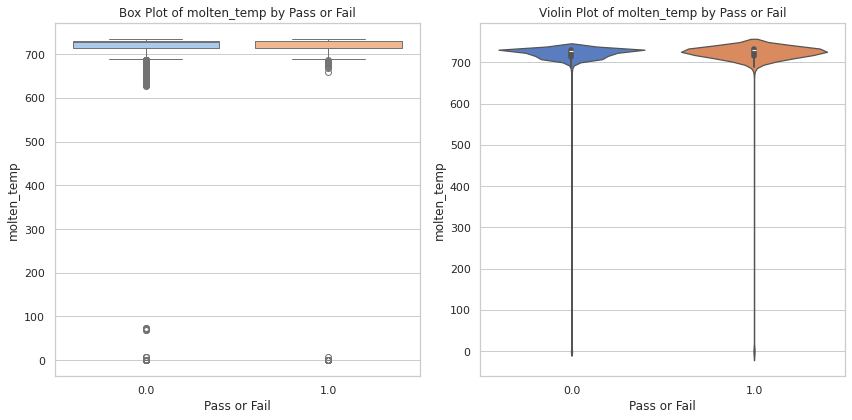

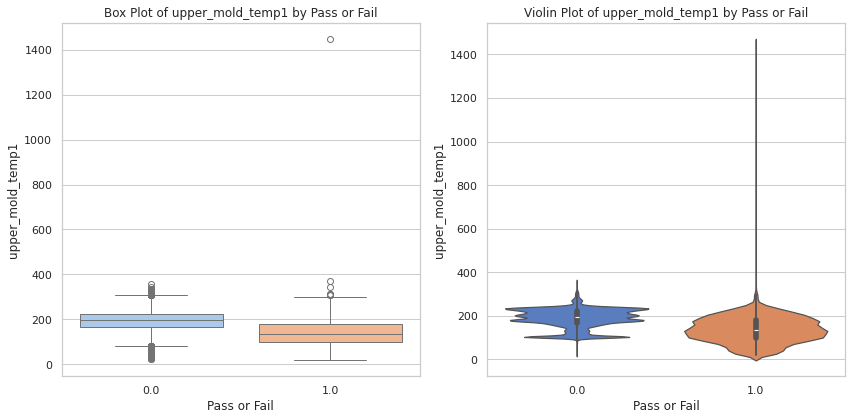

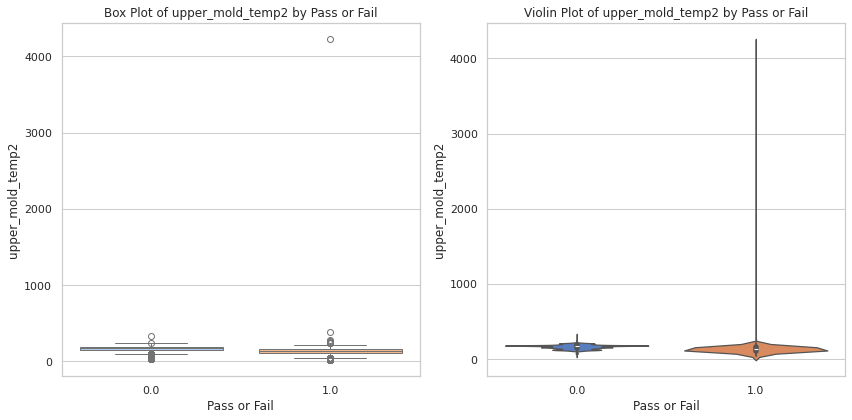

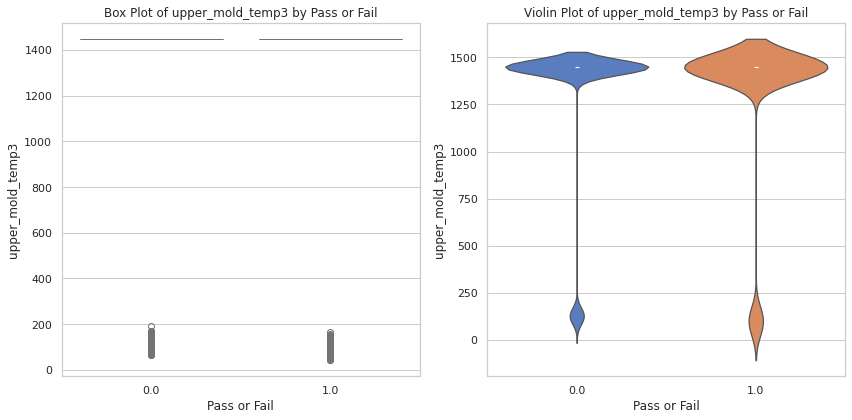

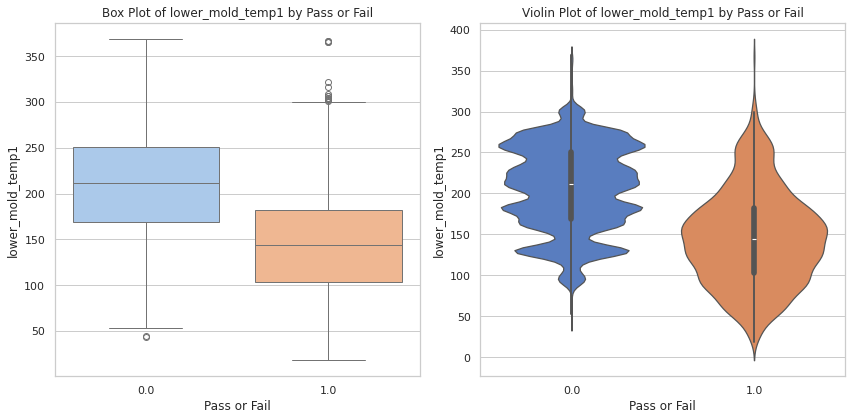

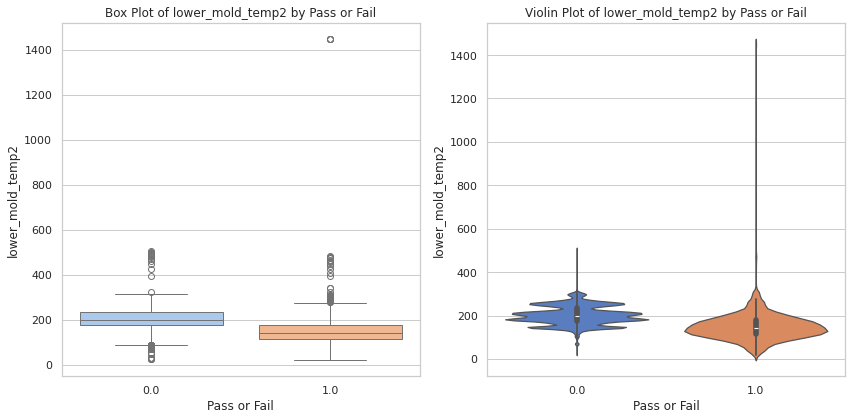

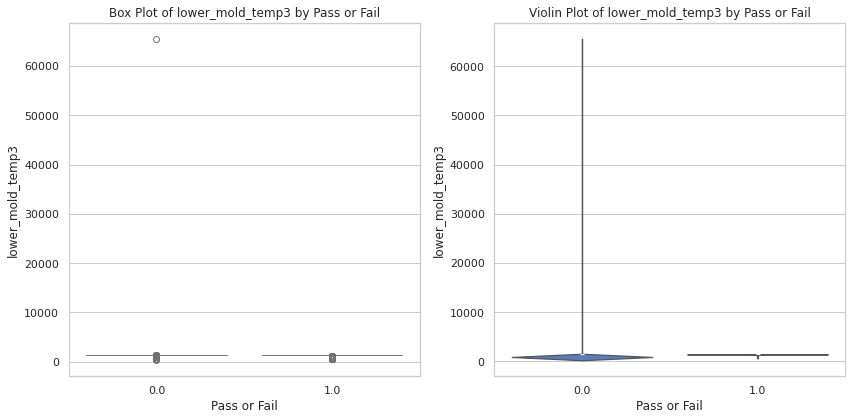

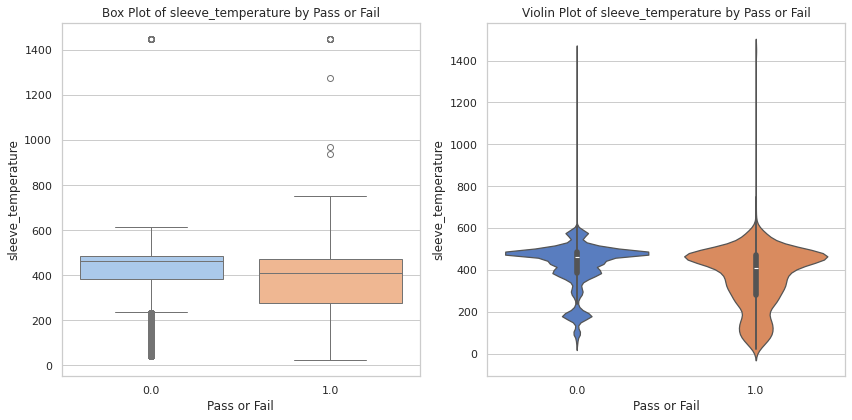

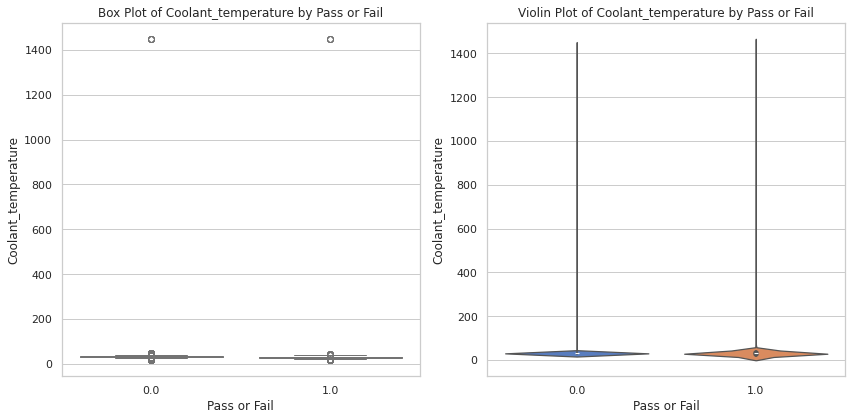

In [ ]:
# 분석에 사용할 변수 목록
variables = [
    'molten_temp', 'upper_mold_temp1', 'upper_mold_temp2', 'upper_mold_temp3',
    'lower_mold_temp1', 'lower_mold_temp2', 'lower_mold_temp3',
    'sleeve_temperature', 'Coolant_temperature'
]

# 그래프 스타일 설정 (선택 사항)
sns.set(style="whitegrid")

# 각 변수에 대해 박스플롯과 바이올린 플롯 생성
for var in variables:
    plt.figure(figsize=(12, 6))
    
    # 박스플롯
    plt.subplot(1, 2, 1)
    sns.boxplot(x='passorfail', y=var, data=df, palette='pastel')
    plt.title(f'Box Plot of {var} by Pass or Fail')
    plt.xlabel('Pass or Fail')
    plt.ylabel(var)
    
    # 바이올린 플롯
    plt.subplot(1, 2, 2)
    sns.violinplot(x='passorfail', y=var, data=df, palette='muted')
    plt.title(f'Violin Plot of {var} by Pass or Fail')
    plt.xlabel('Pass or Fail')
    plt.ylabel(var)
    
    plt.tight_layout()
    plt.show()
